In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
base_path = '/content/drive/MyDrive/KDT_final/data'

## Clinical_patient_brca.txt

In [ ]:
df_p = pd.read_csv(base_path + '/nationwidechildrens.org_clinical_patient_brca.txt', sep = '\t')
df_p.shape

(1099, 112)

In [ ]:
barcode_brca = []
for idx, barcode in enumerate(df_p['bcr_patient_barcode']):
    if idx < 2:
        pass
    else:
        barc = barcode.split('-')[1]
        if barc not in barcode_brca:
            barcode_brca.append(barc)

for idx in range(len(barcode_brca)):
    if idx % 10 == 0:
        print('')
    print(barcode_brca[idx], end = ',')


3C,4H,5L,5T,A1,A2,A7,A8,AC,AN,
AO,AQ,AR,B6,BH,C8,D8,E2,E9,EW,
GI,GM,HN,JL,LD,LL,LQ,MS,OK,OL,
PE,PL,S3,UL,UU,V7,W8,WT,XX,Z7,

## RNASeq_geneExpression 데이터

In [ ]:
df_g = pd.read_csv(base_path + '/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep = '\t')
df_g.shape

(20531, 11070)

In [ ]:
df_g.head(1)

,gene_id,TCGA-OR-A5J1-01A-11R-A29S-07,TCGA-OR-A5J2-01A-11R-A29S-07,TCGA-OR-A5J3-01A-11R-A29S-07,TCGA-OR-A5J5-01A-11R-A29S-07,TCGA-OR-A5J6-01A-31R-A29S-07,TCGA-OR-A5J7-01A-11R-A29S-07,TCGA-OR-A5J8-01A-11R-A29S-07,TCGA-OR-A5J9-01A-11R-A29S-07,TCGA-OR-A5JA-01A-11R-A29S-07,...,TCGA-CG-4449-01A-01R-1157-13,TCGA-CG-4462-01A-01R-1157-13,TCGA-CG-4465-01A-01R-1157-13,TCGA-CG-4466-01A-01R-1157-13,TCGA-CG-4469-01A-01R-1157-13,TCGA-CG-4472-01A-01R-1157-13,TCGA-CG-4474-01A-02R-1157-13,TCGA-CG-4475-01A-01R-1157-13,TCGA-CG-4476-01A-01R-1157-13,TCGA-CG-4477-01A-01R-1157-13
0,?|100130426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 학습용 데이터 생성

### TSS 코드 이용하여 데이터 추출(유방암/그 외로 분리)

In [ ]:
extract_TSS = []

print('TCGA_BRCA barcode : ', end = '')
for i in barcode_brca:
    print(i, end = ' ')
    extract_TSS.append(i)

TCGA_BRCA barcode : 3C 4H 5L 5T A1 A2 A7 A8 AC AN AO AQ AR B6 BH C8 D8 E2 E9 EW GI GM HN JL LD LL LQ MS OK OL PE PL S3 UL UU V7 W8 WT XX Z7 

In [ ]:
len(extract_TSS)
# brca 겹치는 TSS

40

### brc TSS 겹치는 barcode 인덱스 + other 인덱스 추출

In [ ]:
# TSS 겹치는 barcode 인덱스 추출
brca_TSS_idx = []
other_TSS_idx = []

for idx, col in enumerate(df_g.columns):
    if col == 'gene_id':
        brca_TSS_idx.append(idx)
        other_TSS_idx.append(idx)
    elif col.split('-')[1] in extract_TSS:
        brca_TSS_idx.append(idx)
    else:
        # 해당 column 중 TSS 겹치지 않고 null값 없는 열만 추출
        if df_g.loc[:, col].isnull().sum() == 0:
            other_TSS_idx.append(idx)

len(brca_TSS_idx), len(other_TSS_idx)

(1219, 8101)

In [ ]:
# brca 겹치는 데이터
df_brca = df_g.iloc[:, brca_TSS_idx]
df_brca.set_index('gene_id', inplace = True)
df_brca = df_brca.T
df_brca.head(1)

gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
TCGA-3C-AAAU-01A-11R-A41B-07,0.0,16.3644,12.9316,52.1503,408.076,0.0,1187.01,0.0,0.0,0.0,...,415.824,931.957,129.592,1007.78,1658.5,258.494,1208.37,3507.25,1894.93,1180.46


In [ ]:
index_ls = df_brca.index.tolist()

In [ ]:
row_select = []
for idx, r in enumerate(index_ls):
    if '01A' in r.split('-'):
        row_select.append(idx)
        # print(r.split['-'][3])
        # print(r)
    elif '01B' in r.split('-'):
        row_select.append(idx)

len(row_select)

1097

In [ ]:
df_brca_select = df_brca.iloc[row_select, :]
df_brca_select.shape

(1097, 20531)

In [ ]:
# other 데이터
df_n_brca = df_g.iloc[:, other_TSS_idx]
df_n_brca.set_index('gene_id', inplace = True)
df_n_brca = df_n_brca.T
df_n_brca.head(1)

gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
TCGA-OR-A5J1-01A-11R-A29S-07,0.0,3.2661,3.9385,149.135,2034.1,0.0,274.255,1.4409,0.0,0.0,...,183.958,146.974,20.6532,351.585,1050.91,0.4803,648.415,1841.02,1157.54,596.062


In [ ]:
df_n_brca.shape

(8100, 20531)

In [ ]:
index_ls2 = df_n_brca.index.tolist()

In [ ]:
row_select2 = []
for idx, r in enumerate(index_ls2):
    if '01A' in r.split('-'):
        row_select2.append(idx)
        # print(r.split['-'][3])
        # print(r)
    elif '01B' in r.split('-'):
        row_select2.append(idx)
len(row_select2)

7088

In [ ]:
# other 데이터
import random
random.seed(128)
sample_ls = random.sample(row_select2, 1100)
df_n_brca_select = df_n_brca.iloc[sample_ls,:]
df_n_brca_select.head(1)
len(sample_ls)

1100

In [ ]:
df_n_brca_select.shape

(1100, 20531)

In [ ]:
df_brca_select['cancer_type'] = 'breast'
df_n_brca_select['cancer_type'] = 'other'

df_brca_select.shape, df_n_brca_select.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


((1097, 20532), (1100, 20532))

In [ ]:
df_ext = pd.concat([df_brca_select, df_n_brca_select])
df_ext.shape

(2197, 20532)

In [ ]:
df_ext.head(1)

gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,cancer_type
TCGA-3C-AAAU-01A-11R-A41B-07,0.0,16.3644,12.9316,52.1503,408.076,0.0,1187.01,0.0,0.0,0.0,...,931.957,129.592,1007.78,1658.5,258.494,1208.37,3507.25,1894.93,1180.46,breast


## Preprocessing

### gene name 수정 + 겹치는 gene name 제거

In [ ]:
# 컬럼명이 gene_name|숫자로 이루어져있으므로 숫자 제거
gene_col = list(df_ext.columns)

for i in range(len(gene_col)):
    if (gene_col[i] == 'bcr_patient_barcode_all') or (gene_col[i] == 'cancer_type'):
        continue
    else:
        gene_col[i] = gene_col[i].split('|')[0]

df_ext.columns = gene_col
df_ext.head(1)

,?,?,?,?,?,?,?,?,?,?,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,cancer_type
TCGA-3C-AAAU-01A-11R-A41B-07,0.0,16.3644,12.9316,52.1503,408.076,0.0,1187.01,0.0,0.0,0.0,...,931.957,129.592,1007.78,1658.5,258.494,1208.37,3507.25,1894.93,1180.46,breast


In [ ]:
# ?컬럼제거
df_drop_col = df_ext.drop(columns = '?', axis = 1)
df_drop_col.head(1)

,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,cancer_type
TCGA-3C-AAAU-01A-11R-A41B-07,197.09,0.0,0.0,102.963,5798.37,1.3786,68.2424,8.6165,0.3447,649.337,...,931.957,129.592,1007.78,1658.5,258.494,1208.37,3507.25,1894.93,1180.46,breast


In [ ]:
# 컬럼명 중복된 경우 검토
len(df_drop_col.columns), len(df_drop_col.columns.unique())

(20503, 20502)

In [ ]:
df_drop_col.columns.value_counts()

SLC35E2        2
A1BG           1
PNPLA6         1
PNPLA4         1
PNPLA3         1
              ..
GARNL3         1
GAR1           1
GAPVD1         1
GAPT           1
cancer_type    1
Length: 20502, dtype: int64

In [ ]:
for i in range(len(df_drop_col.columns.tolist())):
    if df_drop_col.columns.tolist()[i] == 'SLC35E2':
        print(i)

16272
16273


In [ ]:
df_drop_col.iloc[:, 16271:16273].describe()

,SLC35E1,SLC35E2
count,2197.000000,2197.000000
mean,2157.221073,2227.433909
std,934.849072,1208.106644
min,439.655000,100.295000
25%,1504.600000,1400.060000
50%,2011.890000,2002.040000
75%,2587.820000,2806.920000
max,13537.300000,11199.100000


In [ ]:
# std 더 높은 컬럼 제거
df_drop_col = df_drop_col.drop(df_drop_col.columns[16272], axis = 1)
df_drop_col.shape

(2197, 20501)

### 전부 0인 데이터 제거

In [ ]:
df_drop_col.columns

Index(['A1BG', 'A1CF', 'A2BP1', 'A2LD1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAA1', 'AAAS',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'cancer_type'],
      dtype='object', length=20501)

In [ ]:
gene_pre = df_drop_col.copy()
not_drop_idx = []
drop_idx = []
for col in range(len(gene_pre.columns)):
    # barcode, cancer_type열
    if (col == 0) or (col == 20500):
        not_drop_idx.append(col)

    # 데이터 전부 0이 아닌 컬럼의 인덱스를 not_drop_idx에 저장
    elif gene_pre.iloc[:, col].sum() > 0.0:
        not_drop_idx.append(col)

    else: # 데이터가 전부 0인 것
        drop_idx.append(col)

len(not_drop_idx),len(drop_idx)

(20259, 242)

In [ ]:
drop_idx[0]

4788

In [ ]:
df_drop_col.iloc[:, 4788].value_counts()

0.0    2197
Name: DEFB114, dtype: int64

In [ ]:
gene_pre = gene_pre.iloc[:, not_drop_idx]
gene_pre.shape

(2197, 20259)

### Most frequently mutated

In [ ]:
# frequently mutated data
brca_m_path = '/content/drive/MyDrive/KDT_final/data/gene_set_breast__TCGA__TCGA_BRCA__primary_tumor.2022-11-18.tsv'
brca_mut = pd.read_csv(brca_m_path)
brca_mut.head(1)

,id
0,ENSG00000121879


In [ ]:
# gene id, name 데이터
brca_g_path = '/content/drive/MyDrive/KDT_final/data/TCGA-BRCA.66c6efd3-406c-4b96-ac62-b570d161c825.gene_level_copy_number.v36.tsv'
brca_g = pd.read_csv(brca_g_path, sep = '\t')
brca_g.head(1)

,gene_id,gene_name,chromosome,start,end,copy_number,min_copy_number,max_copy_number
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,NaN,NaN,NaN


In [ ]:
# gene_id에 .숫자 제거
brca_g['gene_id2'] = 0

for idx in range(len(brca_g.index)):
    g_id = brca_g.loc[idx, 'gene_id'].split('.')[0]
    brca_g.loc[idx,'gene_id2'] = g_id

brca_g.head(1)

,gene_id,gene_name,chromosome,start,end,copy_number,min_copy_number,max_copy_number,gene_id2
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,NaN,NaN,NaN,ENSG00000223972


In [ ]:
# 5000개 데이터
brca_mut_top = brca_mut.iloc[:200,:]
brca_mut_top.shape

(200, 1)

In [ ]:
# gene id : name 딕셔너리 생성
g_name_brca = {}
id_list = list(brca_mut_top['id'])
for idx in range(len(brca_g.index)):
    if brca_g.loc[idx, 'gene_id2'] in id_list:
        name = brca_g.loc[idx, 'gene_name']
        id = brca_g.loc[idx, 'gene_id2']
        g_name_brca[id] = name

In [ ]:
brca_mut_top['gene_name'] = 0
for i in range(len(brca_mut_top.index)):
    id = brca_mut_top.loc[i, 'id']
    brca_mut_top.loc[i, 'gene_name'] = g_name_brca[id]

brca_mut_top.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,id,gene_name
0,ENSG00000121879,PIK3CA


In [ ]:
brca_gene_name = list(brca_mut_top['gene_name'].values)
brca_gene_name[:5]

['PIK3CA', 'TP53', 'TTN', 'CDH1', 'GATA3']

In [ ]:
# 상위 5000개 중 겹치는 데이터만
ext_col_idx = []
for idx, col in enumerate(gene_pre.columns):
    if col == 'cancer_type':
        ext_col_idx.append(idx)
    elif col in brca_gene_name:
        ext_col_idx.append(idx)

len(ext_col_idx)

192

In [ ]:
df_pre = gene_pre.iloc[:, ext_col_idx]
df_pre.head(1)

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536,cancer_type
TCGA-3C-AAAU-01A-11R-A41B-07,321.222,0.0,58.592,7.2378,1749.83,412.901,58622.3,3243.58,4534.33,51.0095,...,1693.65,3044.03,3426.6,1817.39,0.3447,14.131,24.1261,143.033,1.034,breast


In [ ]:
df_pre.shape

(2197, 192)

In [ ]:
df_pre.describe()

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,UTRN,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536
count,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,...,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000
mean,385.697376,131.527906,199.640450,99.433918,1612.418176,2432.721311,27208.752989,2127.939790,4344.714924,674.479357,...,2143.356400,1099.749199,1406.987522,1851.025061,4441.554399,31.801995,4.449467,201.403923,268.874628,21.509481
std,947.591539,468.051319,428.286064,617.020191,800.819765,4304.431398,19644.121898,1683.992819,2131.308544,1640.356304,...,1592.763274,735.768052,911.998963,1129.509027,6236.586266,417.554032,25.354999,287.310381,391.513445,83.044750
min,0.000000,0.000000,0.000000,0.000000,89.230400,0.537700,753.311000,77.294700,902.947000,0.000000,...,0.000000,77.247600,70.005600,139.778000,107.156000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.376300,0.695000,12.465400,9.167300,1060.330000,410.034000,12516.400000,1090.110000,3092.470000,80.186200,...,1039.970000,608.027000,812.314000,1140.080000,1713.440000,0.000000,0.000000,52.104800,46.733700,0.000000
50%,51.918200,3.694000,57.741100,22.751400,1434.750000,953.687000,22667.900000,1697.650000,3943.370000,182.124000,...,1737.020000,927.095000,1264.230000,1598.940000,2756.900000,0.000000,0.000000,126.097000,157.319000,0.541900
75%,328.740000,31.483500,216.552000,66.321200,1985.450000,2264.030000,37567.600000,2627.770000,5096.010000,423.286000,...,2813.770000,1377.370000,1874.860000,2275.830000,4728.040000,0.593100,1.621600,249.161000,347.427000,2.574000
max,12102.900000,5927.000000,8237.180000,26153.200000,8156.580000,54514.900000,158468.000000,18831.400000,47079.100000,20479.700000,...,13445.300000,8333.510000,22909.000000,14505.500000,86300.700000,14767.200000,472.644000,5574.820000,8383.620000,955.461000


In [ ]:
df_pre.to_csv('/content/drive/MyDrive/KDT_final/data/extract/gene_exp_01.csv', index = False)

### 데이터 분포 확인

In [ ]:
df_pre = pd.read_csv('/content/drive/MyDrive/KDT_final/data/extract/gene_exp_01.csv')

In [ ]:
df_pre

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536,cancer_type
0,321.2220,0.0000,58.5920,7.2378,1749.830,412.9010,58622.3,3243.580,4534.33,51.0095,...,1693.650,3044.030,3426.600,1817.39,0.3447,14.1310,24.1261,143.0330,1.0340,breast
1,678.6300,1.6313,20.1196,13.0506,1159.330,287.1130,24338.8,4446.980,8177.27,109.2990,...,980.968,2831.970,1570.420,4076.67,0.0000,0.0000,32.0827,125.0680,0.5438,breast
2,0.0000,0.9066,52.5839,6.3463,1467.820,330.9160,18409.8,1101.540,6412.51,166.8180,...,1186.760,718.042,1054.400,3398.01,0.0000,0.0000,116.0470,268.3590,0.0000,breast
3,1430.7000,2.4824,213.4880,33.9264,1288.370,852.2960,27008.3,2193.210,6203.56,211.4190,...,874.224,1230.450,1403.810,3466.69,0.4137,0.8275,95.9868,455.1100,1.6549,breast
4,10.2128,0.4255,65.5319,18.7234,1126.380,1209.3600,48499.6,1777.450,4170.64,262.9790,...,1339.570,1265.530,1770.210,2432.34,0.0000,1.7021,106.8080,543.4040,1.7021,breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,77.2059,0.5252,8.4034,74.0546,1045.170,268.3820,16138.7,755.252,1640.23,786.7650,...,505.252,1068.280,486.870,19396.50,0.0000,2.1008,180.1470,53.5714,0.0000,other
2193,91.8173,5.3824,16.4638,6.6488,883.979,15214.8000,47127.0,2849.180,3964.92,85.1684,...,1370.930,1729.010,2450.570,2312.21,0.0000,0.0000,33.8774,772.8480,0.3166,other
2194,30.5885,1.4921,21.6357,102.2100,1438.030,525.5990,55205.8,1311.200,2501.91,1825.6100,...,1736.080,2654.110,2228.480,48011.20,0.3730,0.0000,349.5290,33.1997,0.7461,other
2195,57.9869,56.8928,532.2760,30.0875,1007.660,3861.0500,23296.0,1608.320,3942.01,298.1400,...,781.729,2313.460,1618.160,3365.43,0.0000,0.0000,207.8770,163.5670,12.0350,other


In [ ]:
df_pre.describe()

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,UTRN,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536
count,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,...,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000
mean,385.697376,131.527906,199.640450,99.433918,1612.418176,2432.721311,27208.752989,2127.939790,4344.714924,674.479357,...,2143.356400,1099.749199,1406.987522,1851.025061,4441.554399,31.801995,4.449467,201.403923,268.874628,21.509481
std,947.591539,468.051319,428.286064,617.020191,800.819765,4304.431398,19644.121898,1683.992819,2131.308544,1640.356304,...,1592.763274,735.768052,911.998963,1129.509027,6236.586266,417.554032,25.354999,287.310381,391.513445,83.044750
min,0.000000,0.000000,0.000000,0.000000,89.230400,0.537700,753.311000,77.294700,902.947000,0.000000,...,0.000000,77.247600,70.005600,139.778000,107.156000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.376300,0.695000,12.465400,9.167300,1060.330000,410.034000,12516.400000,1090.110000,3092.470000,80.186200,...,1039.970000,608.027000,812.314000,1140.080000,1713.440000,0.000000,0.000000,52.104800,46.733700,0.000000
50%,51.918200,3.694000,57.741100,22.751400,1434.750000,953.687000,22667.900000,1697.650000,3943.370000,182.124000,...,1737.020000,927.095000,1264.230000,1598.940000,2756.900000,0.000000,0.000000,126.097000,157.319000,0.541900
75%,328.740000,31.483500,216.552000,66.321200,1985.450000,2264.030000,37567.600000,2627.770000,5096.010000,423.286000,...,2813.770000,1377.370000,1874.860000,2275.830000,4728.040000,0.593100,1.621600,249.161000,347.427000,2.574000
max,12102.900000,5927.000000,8237.180000,26153.200000,8156.580000,54514.900000,158468.000000,18831.400000,47079.100000,20479.700000,...,13445.300000,8333.510000,22909.000000,14505.500000,86300.700000,14767.200000,472.644000,5574.820000,8383.620000,955.461000


### skew : 2 kurt : 4 범위 내의 데이터

#### 일부 skew, kurt log 변환 전후 plot

In [ ]:
df_pik3ca = pd.DataFrame(df_pre['PIK3CA'].apply(lambda x : np.log2(x+1)))
df_pik3ca['cancer_type'] = df_pre['cancer_type']
df_pik3ca

,PIK3CA,cancer_type
0,8.930746,breast
1,8.335006,breast
2,7.766078,breast
3,8.353253,breast
4,8.683742,breast
...,...,...
2192,8.134103,other
2193,9.359095,other
2194,9.468145,other
2195,8.286646,other


In [ ]:
df_pre["PIK3CA"].skew(), df_pre['PIK3CA'].kurt()

(32.348466708831076, 1323.9357598096533)

In [ ]:
df_pik3ca['PIK3CA'].skew(), df_pik3ca['PIK3CA'].kurt()

(-0.32413365582826553, 2.1122592274790746)

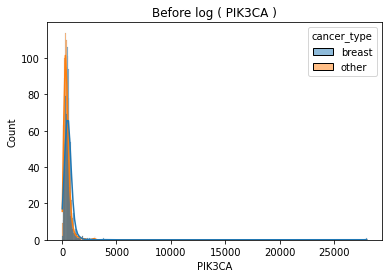

In [ ]:
# log변환 전
sns.histplot(df_pre, x = 'PIK3CA', hue = 'cancer_type', kde = True)
plt.title('Before log ( PIK3CA )')
plt.show()

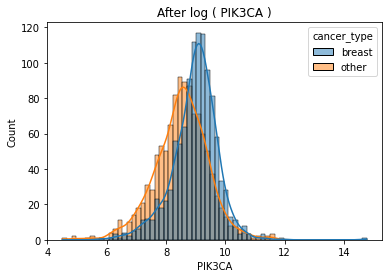

In [ ]:
# log변환 후 PIK3CA
sns.histplot(df_pik3ca, x = 'PIK3CA', hue = 'cancer_type', kde = True)
plt.title('After log ( PIK3CA )')
plt.show()

In [ ]:
df_gata3 = pd.DataFrame(df_pre['GATA3'].apply(lambda x : np.log2(x+1)))
df_gata3['cancer_type'] = df_pre['cancer_type']
df_gata3

,GATA3,cancer_type
0,13.807606,breast
1,12.860843,breast
2,13.323885,breast
3,13.097158,breast
4,13.780283,breast
...,...,...
2192,7.323181,other
2193,6.187269,other
2194,5.607265,other
2195,6.863282,other


In [ ]:
df_pre['GATA3'].skew(), df_pre['GATA3'].kurt()

(1.6201421765193078, 2.8228274354940064)

In [ ]:
df_gata3['GATA3'].skew(), df_gata3['GATA3'].kurt()

(-0.3251580266022017, -1.158338531140932)

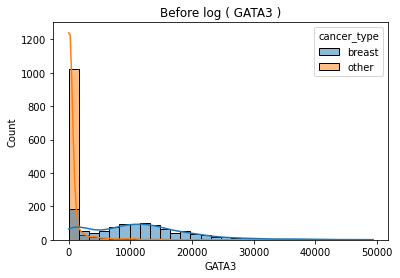

In [ ]:
# log 변환 전
sns.histplot(df_pre, x = 'GATA3', hue = 'cancer_type', kde = True)
plt.title('Before log ( GATA3 )')
plt.show()

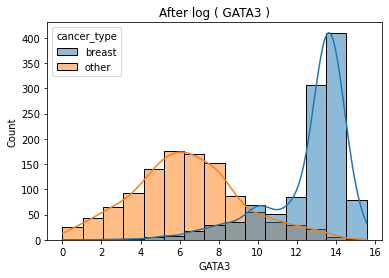

In [ ]:
# log 변환 후 GATA3
sns.histplot(df_gata3, x = 'GATA3', hue = 'cancer_type', kde = True)
plt.title('After log ( GATA3 )')
plt.show()

In [ ]:
df_cdh1 = pd.DataFrame(df_pre['CDH1'].apply(lambda x : np.log2(x+1)))
df_cdh1['cancer_type'] = df_pre['cancer_type']
df_cdh1

,CDH1,cancer_type
0,14.129074,breast
1,13.763005,breast
2,13.102648,breast
3,13.253675,breast
4,9.325139,breast
...,...,...
2192,10.730029,other
2193,13.703276,other
2194,11.116929,other
2195,13.182712,other


In [ ]:
df_pre['CDH1'].skew(), df_pre['CDH1'].kurt()

(1.5553703460110269, 5.087057748918561)

In [ ]:
df_cdh1['CDH1'].skew(), df_cdh1['CDH1'].kurt()

(-2.099419654637189, 4.564549312780708)

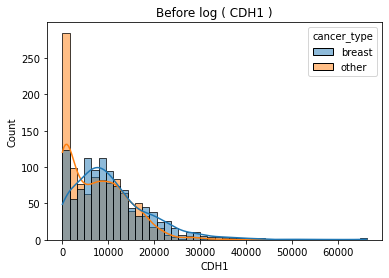

In [ ]:
sns.histplot(df_pre, x = 'CDH1', hue = 'cancer_type', kde = True)
plt.title('Before log ( CDH1 )')
plt.show()

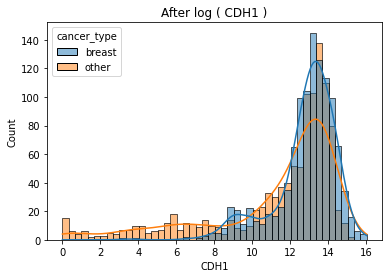

In [ ]:
sns.histplot(df_cdh1, x = 'CDH1', hue = 'cancer_type', kde = True)
plt.title('After log ( CDH1 )')
plt.show()

In [ ]:
df_pre.shape

(2197, 192)

### log2(x+1) 변환 : kurt 4 초과인 것들에 대해서

In [ ]:
col = list(df_pre.columns)
G_idx = [] # 추출한 gene index 담을 리스트
not_G_idx = []

for i, c in enumerate(col):
    # object 데이터 index pass
    if i == 0 or i == 191:
        continue
    # 범위 내
    elif (abs(df_pre[c].skew()) <= 2.0) and (abs(df_pre[c].kurt() <= 4.0)):
        if c not in G_idx:
            G_idx.append(c)
    # kurt 4 초과
    elif (abs(df_pre[c].kurt() > 4.0)):
        if c not in not_G_idx:
            not_G_idx.append(c)

print(len(G_idx))
print(len(not_G_idx))

20
170


In [ ]:
# 유방암 데이터 skew, kurt 검토
df_brca = df_pre[df_pre['cancer_type'] == 'breast']
col = list(df_brca.columns)

for i, c in enumerate(col):
    # object 데이터 index pass
    if i == 0 or i == 191:
        continue
    # 범위 내(이미 있는 경우 제외)
    elif (abs(df_brca[c].skew()) <= 2.0) or (abs(df_brca[c].kurt() <= 4.0)):
        if c in G_idx:
            continue
    # kurt 4 초과
    elif (abs(df_brca[c].kurt() > 4.0)):
        if c in G_idx:
            G_idx.remove(c)
        elif c not in not_G_idx:
            not_G_idx.append(c)

print(len(G_idx))
print(len(not_G_idx))

20
170


In [ ]:
# 다른 암 데이터 skew, kurt 검토
df_n_brca = df_pre[df_pre['cancer_type'] == 'other']
col2 = list(df_n_brca.columns)

for i, c in enumerate(col2):
    # object 데이터 index pass
    if i == 0 or i == 191:
        continue
    # 범위 내(이미 있는 경우 제외)
    elif (abs(df_n_brca[c].skew()) <= 2.0) or (abs(df_n_brca[c].kurt() <= 4.0)):
        if c in G_idx:
            continue
    # kurt 4 초과
    elif (abs(df_n_brca[c].kurt() > 4.0)):
        if c in G_idx:
            G_idx.remove(c)
        elif c not in not_G_idx:
            not_G_idx.append(c)

print(len(G_idx))
print(len(not_G_idx))

18
170


In [ ]:
G_idx # 유방암 다른암 전체 분포가 정규분포인 것은 18개 뿐

['AHNAK',
 'ANKRD12',
 'ARID1A',
 'ARID1B',
 'BAZ2B',
 'BRCA1',
 'CEP350',
 'CREBBP',
 'GOLGB1',
 'GON4L',
 'HERC2',
 'KIAA1109',
 'KIF4A',
 'PTEN',
 'RUNX1',
 'TAF1',
 'TP53',
 'TPR']

In [ ]:
df_pre.head(2)

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536,cancer_type
0,321.222,0.0000,58.5920,7.2378,1749.83,412.901,58622.3,3243.58,4534.33,51.0095,...,1693.650,3044.03,3426.60,1817.39,0.3447,14.131,24.1261,143.033,1.0340,breast
1,678.630,1.6313,20.1196,13.0506,1159.33,287.113,24338.8,4446.98,8177.27,109.2990,...,980.968,2831.97,1570.42,4076.67,0.0000,0.000,32.0827,125.068,0.5438,breast


In [ ]:
df_log = df_pre.copy()

for col in not_G_idx:
    df_log.loc[:, col] = df_log.loc[:, col].apply(lambda x : np.log2(x+1))

df_log.head(2)

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536,cancer_type
0,321.222,0.000000,5.897047,3.042259,10.773823,8.693142,58622.3,11.663816,12.146992,5.700703,...,10.726772,11.572241,11.742983,10.828446,0.427284,3.919435,4.651115,7.170256,1.024320,breast
1,678.630,1.395776,4.400511,3.812560,10.180319,8.170491,24338.8,12.118935,12.997580,6.785276,...,9.939532,11.468100,10.617853,11.993529,0.000000,0.000000,5.048005,6.978058,0.626486,breast


### 이상치 - isolation forest

In [ ]:
df_o = df_log.copy()
df_o.shape

(2197, 192)

In [ ]:
df_b = df_o[df_o['cancer_type'] == 'breast']
df_ot = df_o[df_o['cancer_type'] == 'other']

In [ ]:
# cancer_type 제외 + Transpose
df_b_T = df_b.iloc[:, :-1].T
df_ot_T = df_ot.iloc[:, :-1].T

In [ ]:
df_b_T.shape, df_ot_T.shape

((191, 1097), (191, 1100))

In [ ]:
# contamination : 전체에서 contamination * 100 %
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 50, max_samples = 50, contamination = float(0.1),
                      max_features = 1.0, bootstrap = False, n_jobs = -1,
                      random_state = None, verbose = 0)

fit = clf.fit(df_b_T)
pred = clf.predict(df_b_T)
df_b_T['anomaly'] = pred
outliers_b = df_b_T.loc[df_b_T['anomaly'] == -1]
outlier_index_b = outliers_b.index.tolist()

print(df_b_T['anomaly'].value_counts())

 1    172
-1     19
Name: anomaly, dtype: int64


In [ ]:
len(outlier_index_b)

19

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 50, max_samples = 50, contamination = float(0.1),
                      max_features = 1.0, bootstrap = False, n_jobs = -1, random_state = None, verbose = 0)

fit = clf.fit(df_ot_T)
pred = clf.predict(df_ot_T)
df_ot_T['anomaly'] = pred
outliers_ot = df_ot_T.loc[df_ot_T['anomaly'] == -1]
outlier_index_ot = outliers_ot.index.tolist()

print(df_ot_T['anomaly'].value_counts())

 1    172
-1     19
Name: anomaly, dtype: int64


In [ ]:
len(outlier_index_ot)

19

In [ ]:
outlier_index_b

['AHNAK',
 'ANKRD12',
 'ARID1A',
 'ARID1B',
 'BAZ2B',
 'CEP350',
 'CREBBP',
 'FOXA1',
 'GATA3',
 'GOLGB1',
 'GON4L',
 'HERC2',
 'KIAA1109',
 'KIF4A',
 'PTEN',
 'RUNX1',
 'TAF1',
 'TP53',
 'TPR']

순위(0부터) : 194,43,183,180,132,68,196,81,77,16,18,126,36,117,1,176,91,189,46 - 다시

In [ ]:
outlier_index_ot

['AHNAK',
 'ANKRD12',
 'ARID1A',
 'ARID1B',
 'BAZ2B',
 'BRCA1',
 'CEP350',
 'CREBBP',
 'FOXA1',
 'GOLGB1',
 'GON4L',
 'HERC2',
 'KIAA1109',
 'KIF4A',
 'PTEN',
 'RUNX1',
 'TAF1',
 'TP53',
 'TPR']

순위(0부터) : 194,66,43,183,180,132,68,196,81,77,16,67,18,126,36,117,1,176,91 - 다시

In [ ]:
def gene_hist_outlier(df, col_list):
    row = int(len(col_list)/3+1)
    
    fig, ax = plt.subplots(row, 3, figsize = (12, row*2))
    for col, ax in zip(col_list, ax.flatten()):
        h = sns.histplot(data = df, x = col, ax = ax, hue = 'cancer_type', kde = True)
    fig.tight_layout()
    plt.show()

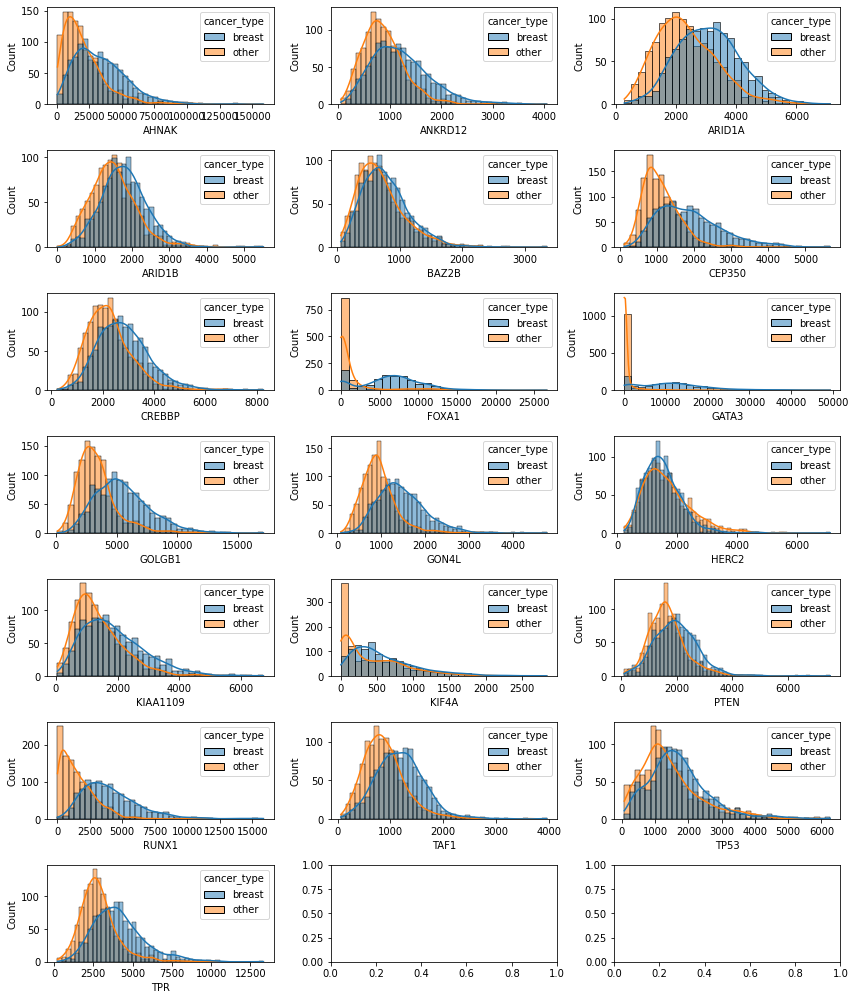

In [ ]:
gene_hist_outlier(df_log, outlier_index_b)

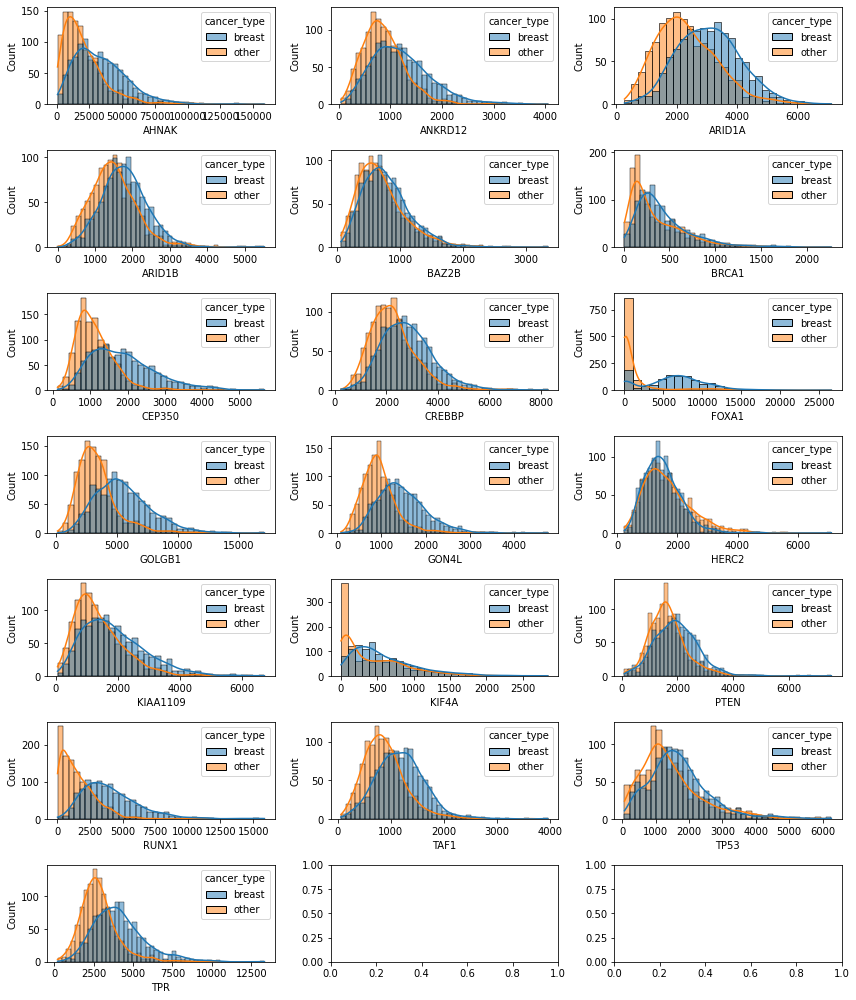

In [ ]:
gene_hist_outlier(df_log, outlier_index_ot)

#### log 변환된 값인지 확인

In [ ]:
outlier_log_list = []
for i_b in outlier_index_b:
    if i_b not in not_G_idx:
        outlier_log_list.append(i_b)
        print(i_b)

AHNAK
ANKRD12
ARID1A
ARID1B
BAZ2B
CEP350
CREBBP
FOXA1
GATA3
GOLGB1
GON4L
HERC2
KIAA1109
KIF4A
PTEN
RUNX1
TAF1
TP53
TPR


In [ ]:
for i_ot in outlier_index_ot:
    if i_ot not in not_G_idx:
        print(i_ot)
        if i_ot not in outlier_log_list:
            outlier_log_list.append(i_ot)

AHNAK
ANKRD12
ARID1A
ARID1B
BAZ2B
BRCA1
CEP350
CREBBP
FOXA1
GOLGB1
GON4L
HERC2
KIAA1109
KIF4A
PTEN
RUNX1
TAF1
TP53
TPR


* log 변환하지 않은 값

#### 이상치 로그 변환

In [ ]:
outlier_log_list

['AHNAK',
 'ANKRD12',
 'ARID1A',
 'ARID1B',
 'BAZ2B',
 'CEP350',
 'CREBBP',
 'FOXA1',
 'GATA3',
 'GOLGB1',
 'GON4L',
 'HERC2',
 'KIAA1109',
 'KIF4A',
 'PTEN',
 'RUNX1',
 'TAF1',
 'TP53',
 'TPR',
 'BRCA1']

In [ ]:
len(outlier_log_list)

20

In [ ]:
df_log2 = df_log.copy()
for col in outlier_log_list:
    df_log2.loc[:, col] = df_log2.loc[:, col].apply(lambda x : np.log2(x+1))

df_log2.head(2)

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536,cancer_type
0,321.222,0.000000,5.897047,3.042259,10.773823,8.693142,15.839187,11.663816,12.146992,5.700703,...,10.726772,11.572241,11.742983,10.828446,0.427284,3.919435,4.651115,7.170256,1.024320,breast
1,678.630,1.395776,4.400511,3.812560,10.180319,8.170491,14.571030,12.118935,12.997580,6.785276,...,9.939532,11.468100,10.617853,11.993529,0.000000,0.000000,5.048005,6.978058,0.626486,breast


In [ ]:
df_log['AHNAK']

0       58622.3
1       24338.8
2       18409.8
3       27008.3
4       48499.6
         ...   
2192    16138.7
2193    47127.0
2194    55205.8
2195    23296.0
2196     1981.3
Name: AHNAK, Length: 2197, dtype: float64

In [ ]:
df_log2['AHNAK']

0       15.839187
1       14.571030
2       14.168265
3       14.721169
4       15.565715
          ...    
2192    13.978326
2193    15.524297
2194    15.752558
2195    14.507857
2196    10.952960
Name: AHNAK, Length: 2197, dtype: float64

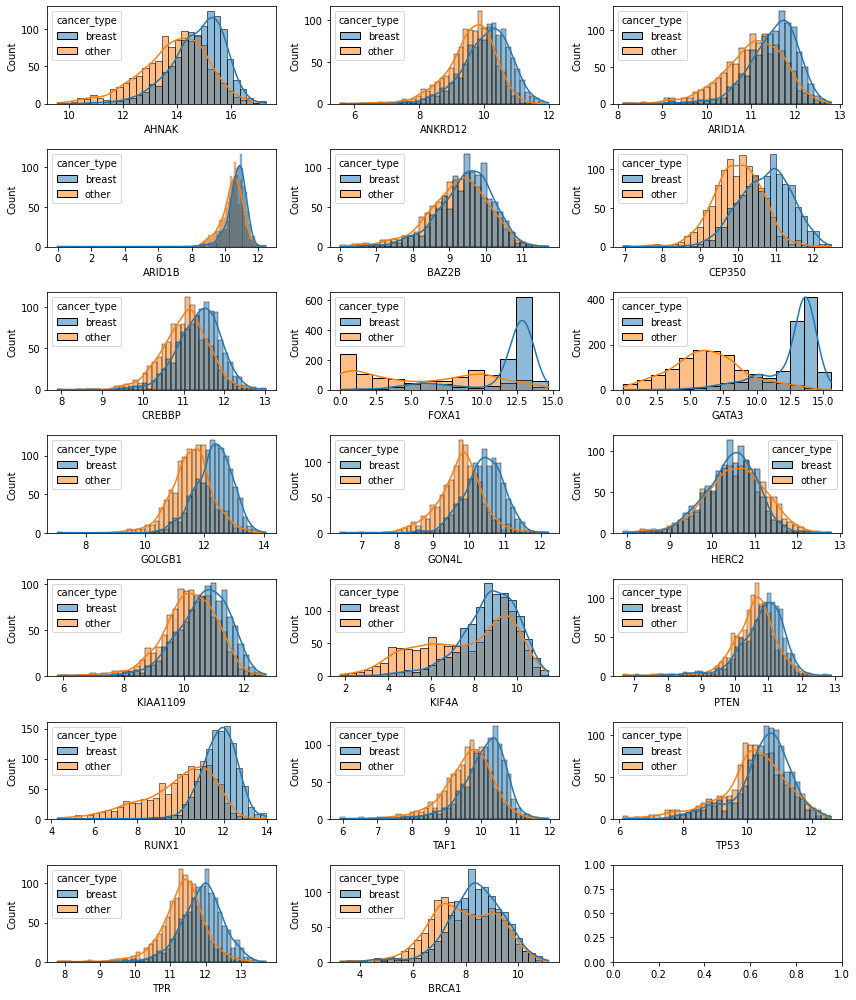

In [ ]:
# log 변환 후 그래프
gene_hist_outlier(df_log2, outlier_log_list)

### 데이터 중간 저장

In [ ]:
df_log.to_csv('/content/drive/MyDrive/KDT_final/data/extract/gene_log_kurt.csv', index = False)
df_log2.to_csv('/content/drive/MyDrive/KDT_final/data/extract/gene_log_kurt_outlier.csv', index = False)

## 모델링

In [ ]:
# df_n = pd.read_csv('/content/drive/MyDrive/KDT_final/data/extract/gene_exp_pre.csv')
# df_n.head(1)

,ABCB10,ABCB7,ABCG1,ACIN1,ACTG1,ACVR2A,ADCY7,ADD1,ADNP2,ADNP,...,ZNF721,ZNF770,ZNF786,ZNF790,ZNF791,ZNF800,ZNF827,ZNF84,ZNF91,cancer_type
0,532.842,607.634,1020.19,3280.46,53008.5,212.655,326.392,4005.97,843.38,3426.94,...,630.622,1798.79,434.27,176.81,458.396,565.24,269.523,950.569,1115.32,breast


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

def DNN(train, test, val, shape, epoch, opt = False):
    X_train, y_train = train[0], train[1]
    X_test, y_test = test[0], test[1]
    X_val, y_val = val[0], val[1]

    model = Sequential([
        Dense(54, input_shape = (shape,), activation = 'relu'),
        Dense(96, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(54, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ])

    model.summary()

    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    if opt == True:
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

        hist = model.fit(X_train, y_train, epochs = epoch,
                         validation_data = (X_val, y_val), verbose = 1,
                         callbacks = [early_stopping])
        
    else:
        hist = model.fit(X_train, y_train, epochs = epoch,
                         validation_data = (X_val, y_val), verbose = 1)

    return model,hist

In [ ]:
# model plot
def model_plot(hist):
    import matplotlib.pyplot as plt

    his_dict = hist.history
    loss = his_dict['loss']
    val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

    epochs = range(1,len(loss)+1 )
    fig = plt.figure(figsize= (10,5) )

    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
    ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
    ax1.set_title('train and val loss')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.legend()

    acc = his_dict['accuracy']
    val_acc = his_dict['val_accuracy']

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
    ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
    ax2.set_title('train and val acc')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('acc')
    ax2.legend()

    plt.show()

In [ ]:
# XGBoost model
def XGB(train, test, val, n_estimators, max_depth):
    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    X_train, y_train = train[0], train[1]
    X_test, y_test = test[0], test[1]
    X_val, y_val = val[0], val[1]

    params = { 'n_estimators' : [n_estimators],
            'max_depth' : [max_depth]
                }

    xgb = XGBClassifier(booster = 'gbtree', objective = 'binary:logistic', eval_metric = 'error', random_state = 2, n_jobs = -1)
    xgb_grid_cv = GridSearchCV(xgb, param_grid = params, cv = 3, n_jobs = -1)
    xgb_grid_cv.fit(X_train, y_train)

    print('최적 하이퍼 파라미터: ', xgb_grid_cv.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(xgb_grid_cv.best_score_))

    from sklearn.metrics import accuracy_score

    best_model_xgb = xgb_grid_cv.best_estimator_
    best_model_xgb.fit(X_train, y_train)
    y_pred = best_model_xgb.predict(X_test)
    print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

    ft_importance_values = best_model_xgb.feature_importances_

    feature = X_train.columns
    importances = pd.DataFrame()
    importances['feature'] = feature
    importances['importances'] = ft_importance_values
    importances.sort_values('importances', ascending = False, inplace = True)

    # 시각화
    size = int(len(X_train.columns) / 10)
    plt.figure(figsize=(15, size))
    plt.title('Feature Importance')
    sns.barplot(x='importances', y='feature', data = importances)
    plt.show()

    return importances

### 모델링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_log2.iloc[:, :-1]
y = df_log2.iloc[:, -1]

le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
print(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, random_state = 2, test_size = 0.2, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 2, test_size = 0.2, shuffle = True)

X_train.shape

['breast' 'other']


(1405, 191)

In [ ]:
shape = X_train.shape[1]
shape

191

In [ ]:
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

model,hist = DNN(train, test, val, shape, 50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 54)                10368     
                                                                 
 dense_1 (Dense)             (None, 96)                5280      
                                                                 
 dense_2 (Dense)             (None, 128)               12416     
                                                                 
 dense_3 (Dense)             (None, 54)                6966      
                                                                 
 dense_4 (Dense)             (None, 2)                 110       
                                                                 
Total params: 35,140
Trainable params: 35,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================] - 

In [ ]:
# 예측 결과 비교
results = model.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test[i]:
        pass
    else:
        print(pred, ':', y_test[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step
Non-match
pred : orig
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
======== 17 ========
14/14 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9614


[0.17383727431297302, 0.9613636136054993]

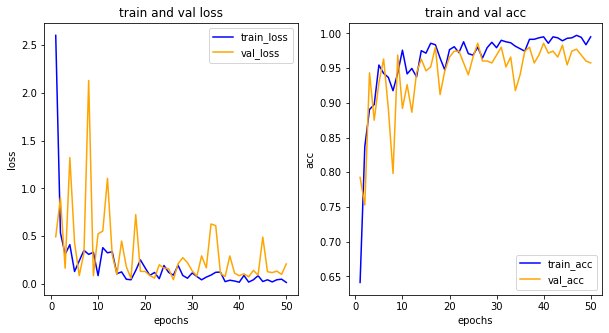

In [ ]:
model_plot(hist)

최적 하이퍼 파라미터:  {'max_depth': 5, 'n_estimators': 30}
최고 예측 정확도: 0.9609
예측 정확도: 0.9682


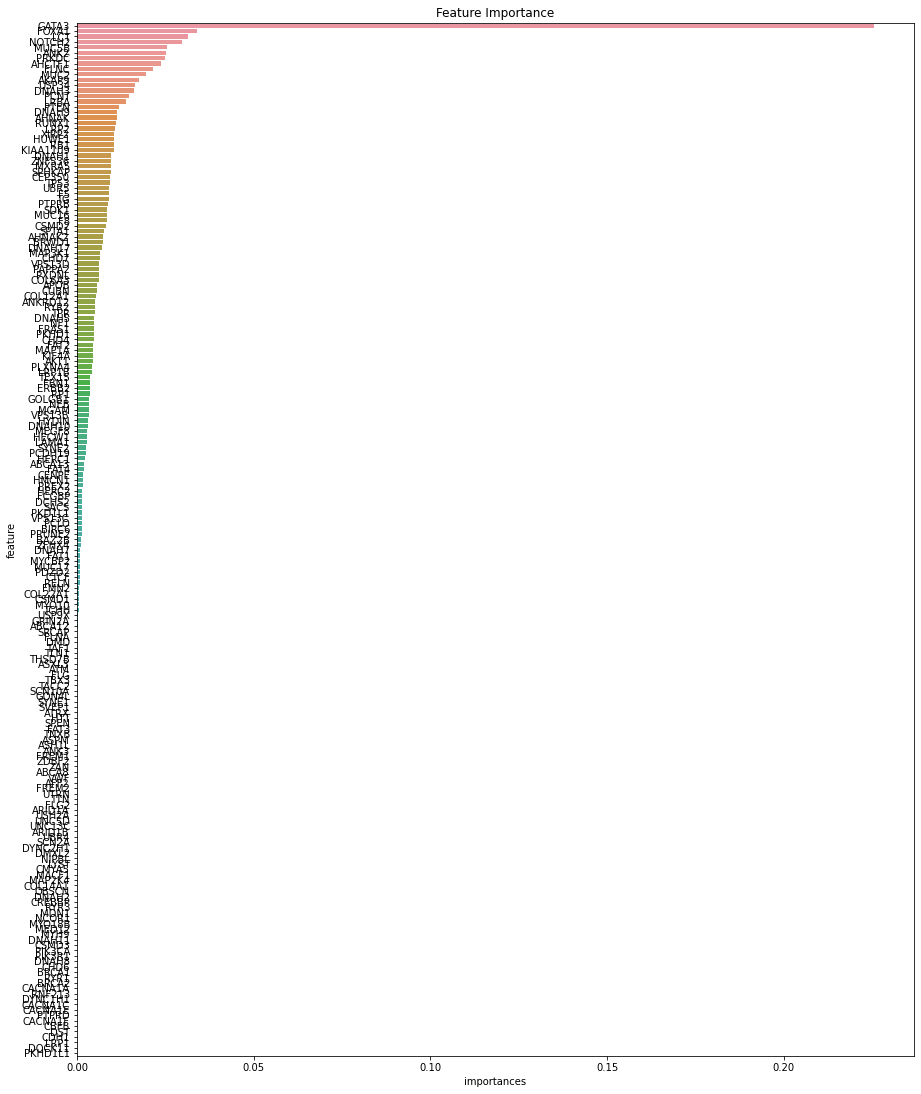

In [ ]:
importances = XGB(train, test, val, 30, 5)

In [ ]:
importances

,feature,importances
82,GATA3,0.225570
78,FOXA1,0.033906
96,LCT,0.031332
123,NOTCH2,0.029851
113,MUC5B,0.025612
...,...,...
61,DST,0.000000
30,CDH1,0.000000
98,LRP1,0.000000
60,DOCK11,0.000000


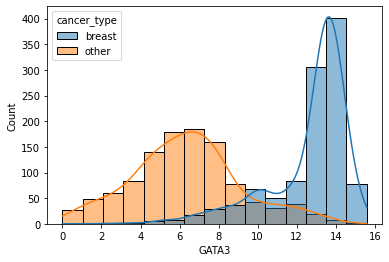

In [ ]:
sns.histplot(data = df_log2, x = 'GATA3', hue = 'cancer_type', kde = True)

In [ ]:
imp_ls = list(importances[importances['importances'] > 0.0]['feature'])
print(len(imp_ls))
imp_ls

114


['GATA3',
 'FOXA1',
 'LCT',
 'NOTCH2',
 'MUC5B',
 'ANK2',
 'PRKDC',
 'AHCTF1',
 'FLNC',
 'MUC2',
 'AKAP9',
 'USP34',
 'DNAH3',
 'PCNT',
 'LRBA',
 'PTEN',
 'DNAH9',
 'AHNAK',
 'RUNX1',
 'LRP2',
 'XIRP2',
 'HUWE1',
 'RB1',
 'KIAA1109',
 'DNAH1',
 'ZNF536',
 'MXRA5',
 'SPHKAP',
 'CEP350',
 'TP53',
 'UBR5',
 'F5',
 'TG',
 'PTPRB',
 'SDK1',
 'MUC16',
 'F8',
 'CSMD2',
 'SPTA1',
 'AHNAK2',
 'BRWD1',
 'DNAH17',
 'MAP3K1',
 'CHD7',
 'VPS13D',
 'PAPPA2',
 'PXDNL',
 'COL6A3',
 'APOB',
 'CUBN',
 'COL12A1',
 'ANKRD12',
 'RYR2',
 'TPR',
 'DNAH5',
 'NF1',
 'FRAS1',
 'PKHD1',
 'CHD4',
 'FAT2',
 'MAP1A',
 'KIF4A',
 'AKT1',
 'PLXNA4',
 'LRP1B',
 'TEX15',
 'FBN1',
 'ERBB2',
 'RP1',
 'GOLGB1',
 'NEB',
 'MGAM',
 'VPS13B',
 'HYDIN',
 'DNAH10',
 'MEGF8',
 'HECW1',
 'LAMA1',
 'SYNE2',
 'PCDH19',
 'HERC1',
 'ABCA13',
 'FAT4',
 'CENPE',
 'HMCN1',
 'PREX2',
 'HERC2',
 'FCGBP',
 'DCHS2',
 'SACS',
 'PKD1L1',
 'VPS13C',
 'PCLO',
 'BIRC6',
 'PRUNE2',
 'BAZ2B',
 'ZFHX4',
 'DNAH7',
 'FAT1',
 'MYCBP2',
 'MUC17',
 'PDZD

In [ ]:
def gene_hist(df, col_list):
    row = int(len(col_list)/3)
    
    fig, ax = plt.subplots(row, 3, figsize = (12, row*2))
    for col, ax in zip(col_list, ax.flatten()):
        h = sns.histplot(data = df, x = col, ax = ax, hue = 'cancer_type', kde = True)
    fig.tight_layout()
    plt.show()

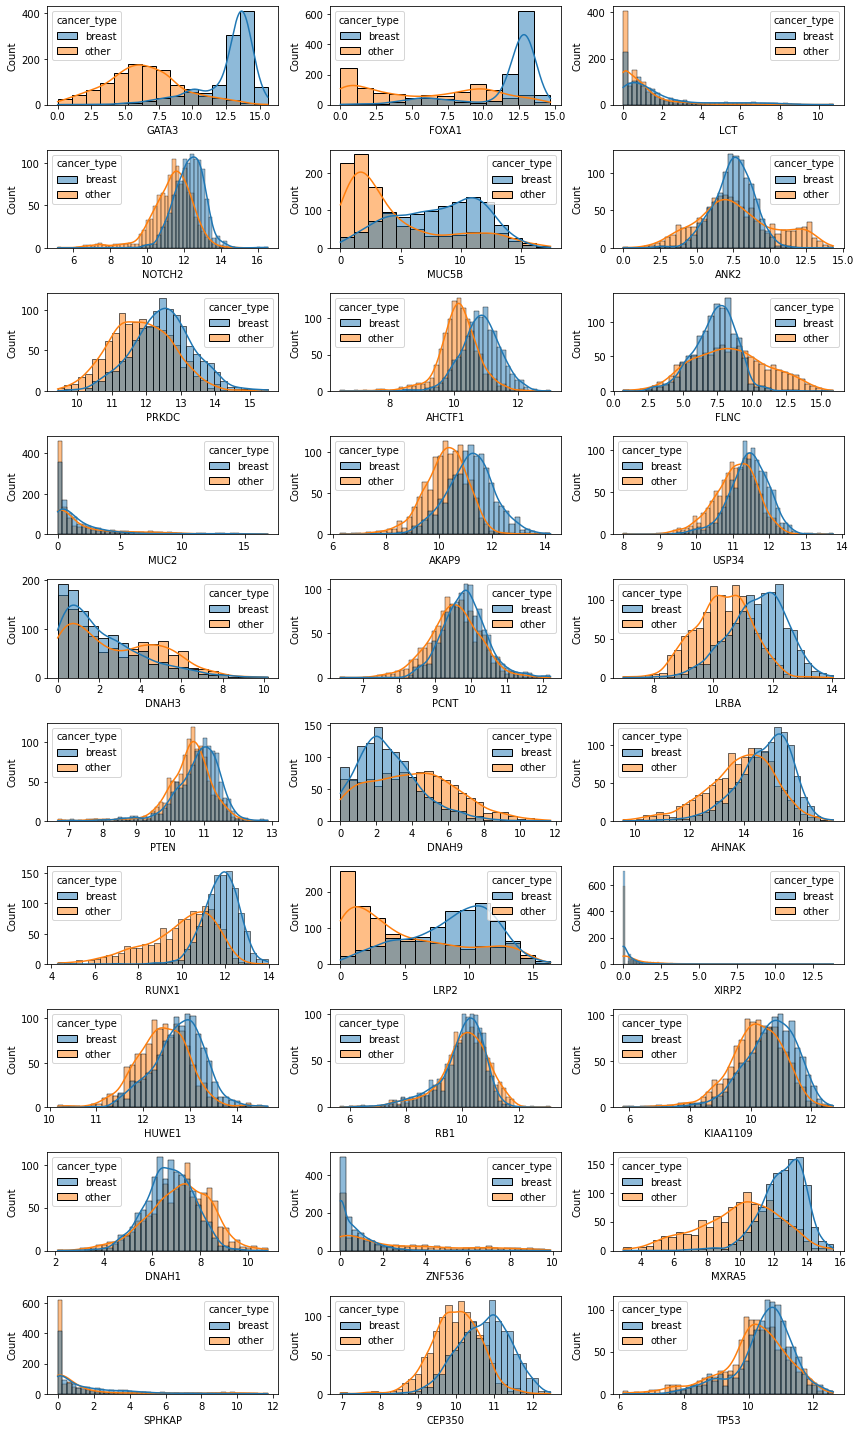

In [ ]:
gene_hist(df_log2, imp_ls[:30])

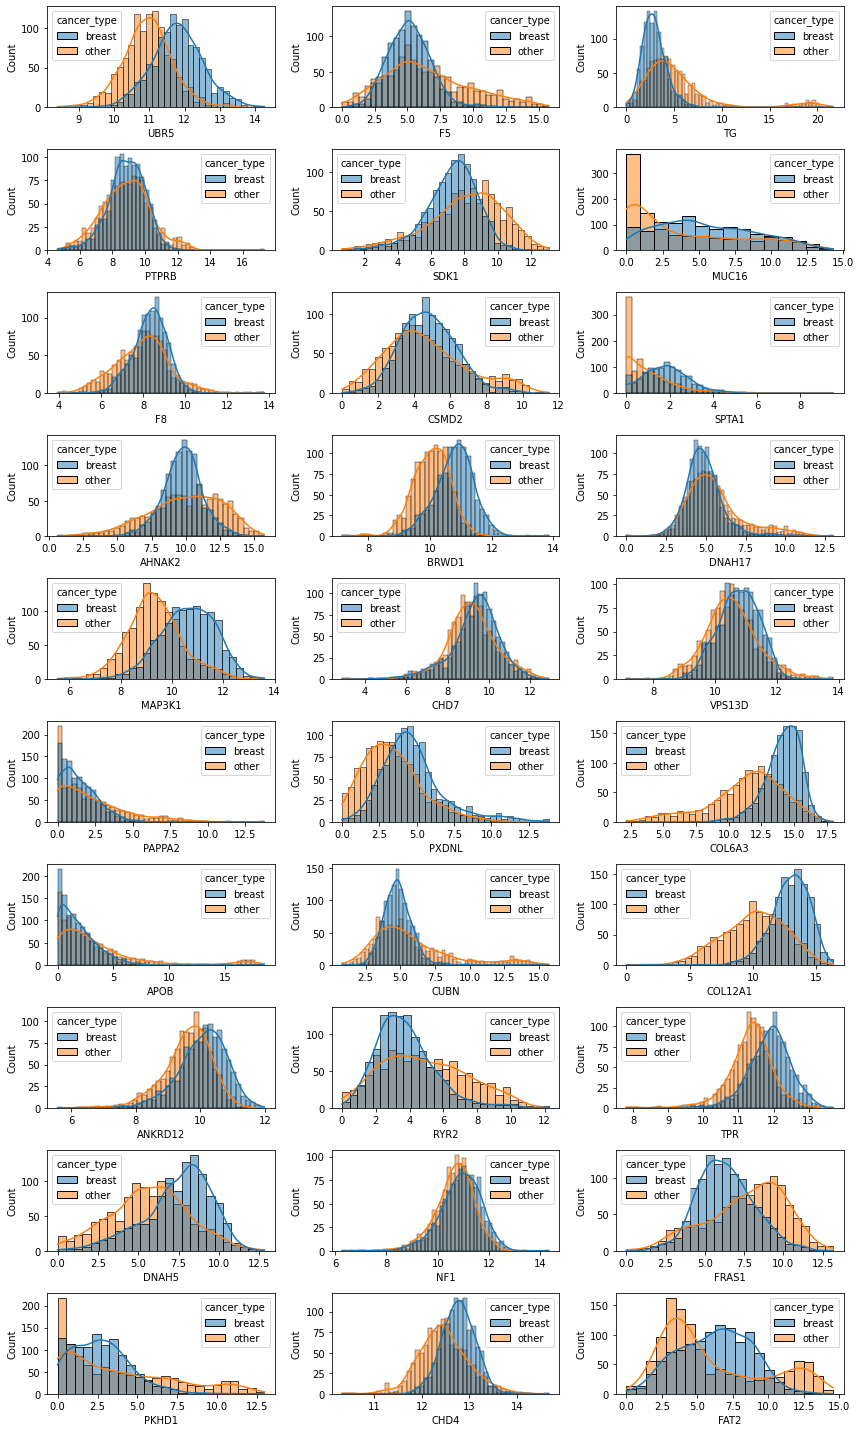

In [ ]:
# 주피터노트북 01A 통계
gene_hist(df_log2, imp_ls[30:60])

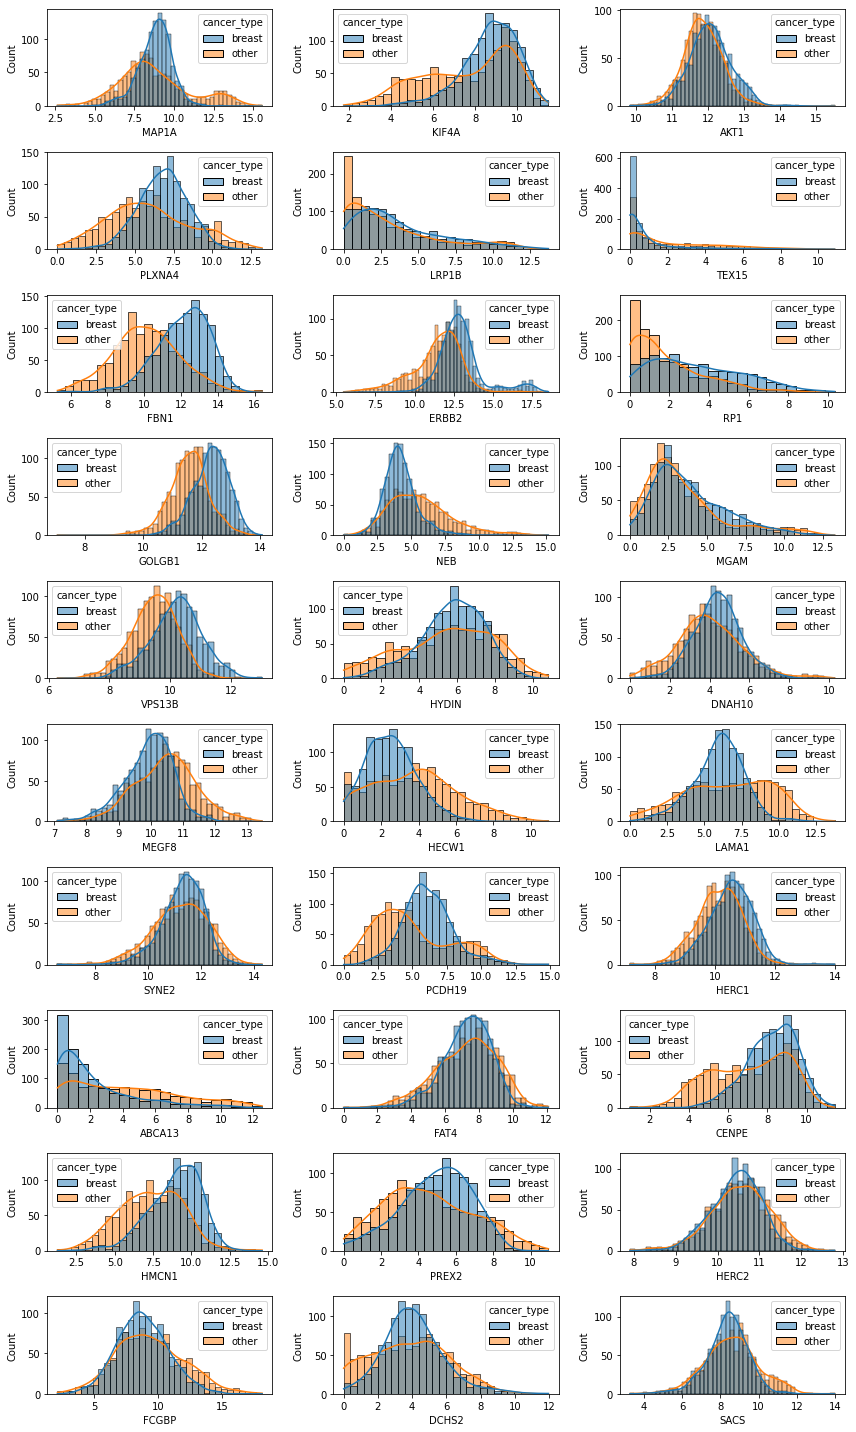

In [ ]:
gene_hist(df_log2, imp_ls[60:90])

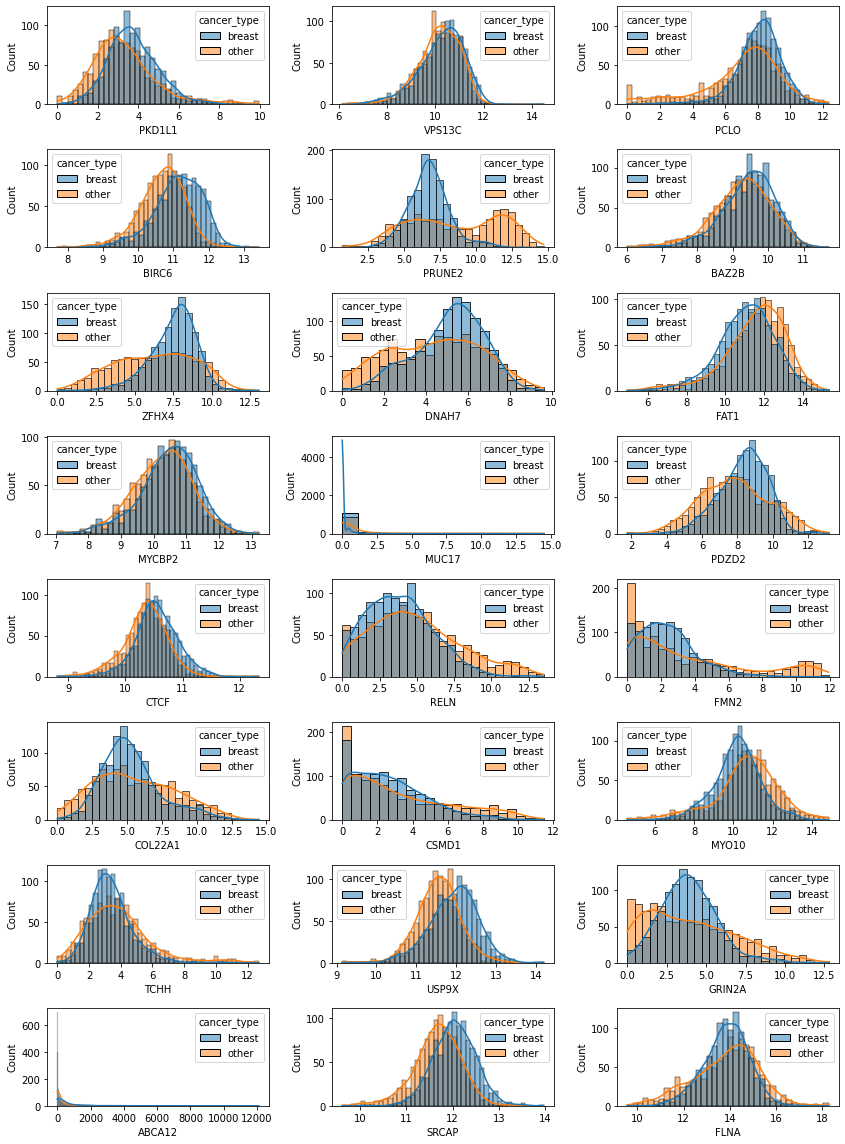

In [ ]:
gene_hist(df_log2, imp_ls[90:120])

### 추가 모델링

##### 모델링 L2 규제

In [ ]:
from tensorflow import keras
from keras.regularizers import l2

model2 = Sequential([
    Dense(192, input_shape = (191,), activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(154, activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(128, activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(54, activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(2, activation = 'softmax')
])

model2.summary()

model2.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    
hist2 = model2.fit(X_train, y_train, epochs = 50,
                    validation_data = (X_val, y_val), verbose = 1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 192)               36864     
                                                                 
 dense_21 (Dense)            (None, 154)               29722     
                                                                 
 dense_22 (Dense)            (None, 128)               19840     
                                                                 
 dense_23 (Dense)            (None, 54)                6966      
                                                                 
 dense_24 (Dense)            (None, 2)                 110       
                                                                 
Total params: 93,502
Trainable params: 93,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================] 

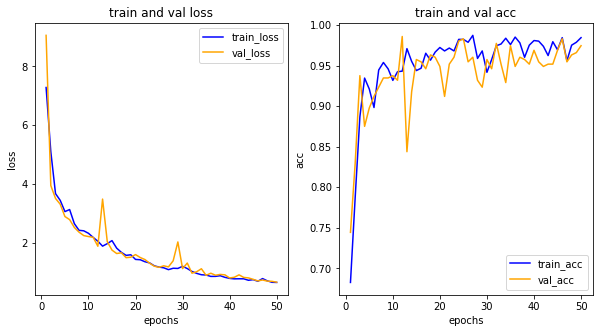

In [ ]:
model_plot(hist2)

In [ ]:
# 예측 결과 비교
results = model2.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test[i]:
        pass
    else:
        print(pred, ':', y_test[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model2.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step
Non-match
pred : orig
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
======== 6 ========
14/14 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.9864


[0.6493908166885376, 0.9863636493682861]

##### Dropout 0.2 적용

In [ ]:
from tensorflow import keras
from keras.regularizers import l2
from keras.layers import Dropout

model3 = Sequential([
    Dense(192, input_shape = (191,), activation = 'relu'),
    Dense(154, activation = 'relu'),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(54, activation = 'relu'),
    Dense(2, activation = 'softmax')
])

model3.summary()

model3.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    
hist3 = model3.fit(X_train, y_train, epochs = 50,
                    validation_data = (X_val, y_val), verbose = 1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 192)               36864     
                                                                 
 dense_26 (Dense)            (None, 154)               29722     
                                                                 
 dropout_4 (Dropout)         (None, 154)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               19840     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 54)                6966      
                                                                 
 dense_29 (Dense)            (None, 2)                

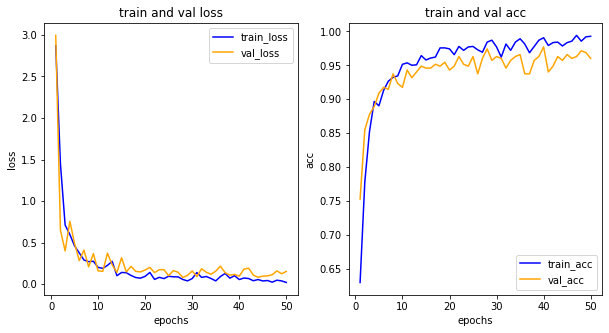

In [ ]:
model_plot(hist3)

In [ ]:
# 예측 결과 비교
results = model3.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test[i]:
        pass
    else:
        print(pred, ':', y_test[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model3.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step
Non-match
pred : orig
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
======== 14 ========
14/14 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9682


[0.1360226422548294, 0.9681817889213562]

##### 모델링 L2 규제 + Dropout

In [ ]:
from tensorflow import keras
from keras.regularizers import l2

model4 = Sequential([
    Dense(192, input_shape = (191,), activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(154, activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dropout(0.2),
    Dense(128, activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dropout(0.2),
    Dense(54, activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(2, activation = 'softmax')
])

model4.summary()

model4.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    
hist4 = model4.fit(X_train, y_train, epochs = 50,
                    validation_data = (X_val, y_val), verbose = 1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 192)               36864     
                                                                 
 dense_31 (Dense)            (None, 154)               29722     
                                                                 
 dropout_6 (Dropout)         (None, 154)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               19840     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 54)                6966      
                                                                 
 dense_34 (Dense)            (None, 2)                

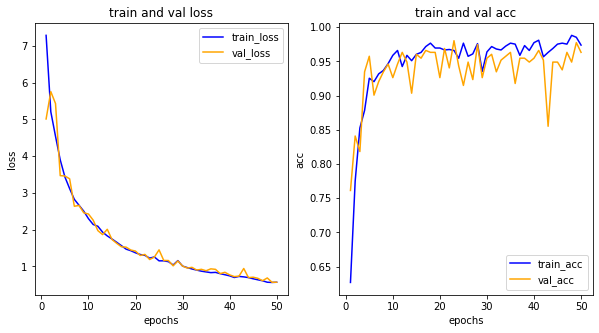

In [ ]:
model_plot(hist4)

In [ ]:
# 예측 결과 비교
results = model4.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

y_pred = []
for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test[i]:
        pass
    else:
        print(pred, ':', y_test[i])
        cnt += 1
    y_pred.append(pred)

print('======== {} ========'.format(cnt))

model4.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step
Non-match
pred : orig
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
======== 12 ========
14/14 [==============================] - 0s 5ms/step - loss: 0.5539 - accuracy: 0.9727


[0.5539070963859558, 0.9727272987365723]

In [ ]:
y_pred_a = np.array(y_pred)

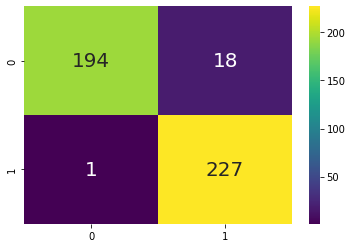

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_a)
TN, FP, FN, TP = cm.ravel()

sns.heatmap(cm, annot = True, annot_kws = {'size' : 20}, cmap = 'viridis', fmt = 'd')

##### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth' : [2, 4, 5],
          'n_estimators' : [15,30,50]}

rf = RandomForestClassifier(random_state = 42)
grid_c = GridSearchCV(rf, params, scoring = 'accuracy', cv = 5, return_train_score = True, n_jobs = -1)
grid_c.fit(X_train, y_train)

output = pd.DataFrame(grid_c.cv_results_)

best_params = grid_c.best_params_
print('best_parameter : ', best_params)

best_score = grid_c.best_score_
print('best_score : ', best_score)

best_parameter :  {'max_depth': 5, 'n_estimators': 30}
best_score :  0.9715302491103204


In [ ]:
from sklearn.metrics import accuracy_score

best_rf = grid_c.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print('accuracy_score: {:.4f}'.format(accuracy_score(y_test,y_pred)))

accuracy_score: 0.9682


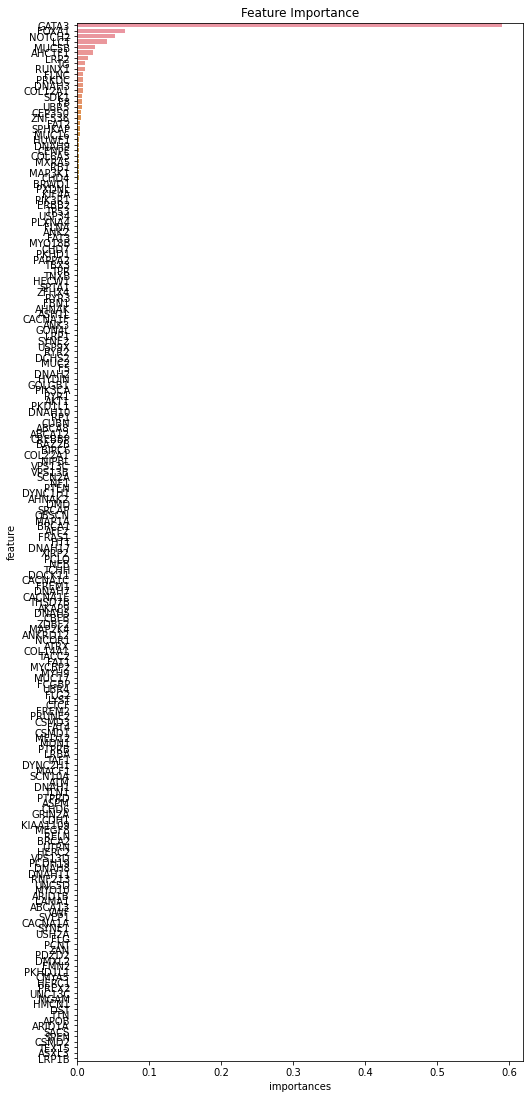

In [ ]:
feature_imp = best_rf.feature_importances_
ft_s = pd.DataFrame()
ft_s['feature'] = X_train.columns
ft_s['importances'] = feature_imp
ft_s.sort_values(by = 'importances', ascending=False, inplace = True)

plt.figure(figsize=(8,len(X_train.columns)/10))
plt.title('Feature Importance')
sns.barplot(x='importances', y='feature', data = ft)
plt.show()

In [ ]:
ft_s

,feature,importances
82,GATA3,0.106597
147,RUNX1,0.093341
83,GOLGB1,0.046141
114,MXRA5,0.042778
78,FOXA1,0.042698
...,...,...
92,HYDIN,0.000000
19,ATRX,0.000000
11,ANKRD12,0.000000
162,TACC2,0.000000


In [ ]:
imp_ls2 = list(ft_s[ft_s['importances'] > 0.0]['feature'])
print(len(imp_ls2))
imp_ls2

163


['GATA3',
 'RUNX1',
 'GOLGB1',
 'MXRA5',
 'FOXA1',
 'AHCTF1',
 'COL6A3',
 'UBR5',
 'MUC5B',
 'MAP3K1',
 'CEP350',
 'FBN1',
 'LRP2',
 'LRBA',
 'COL12A1',
 'TG',
 'GON4L',
 'PRUNE2',
 'ZNF536',
 'TPR',
 'MUC16',
 'ABCA13',
 'FRAS1',
 'TBX3',
 'BRWD1',
 'DNAH5',
 'NEB',
 'PCDH19',
 'SPTA1',
 'HECW1',
 'CMYA5',
 'LAMA1',
 'FAT2',
 'FLNC',
 'AKAP9',
 'BRCA2',
 'KIF4A',
 'RP1',
 'F5',
 'ASH1L',
 'AHNAK2',
 'MEGF8',
 'F8',
 'ASPM',
 'DST',
 'ZFHX4',
 'FLG2',
 'PRKDC',
 'FLG',
 'SYNE1',
 'RYR2',
 'CHD4',
 'DNAH3',
 'PIK3R1',
 'DMD',
 'LRP1',
 'FAT1',
 'TCHH',
 'AFF2',
 'SDK1',
 'ABCA12',
 'DNAH9',
 'RYR3',
 'ANK3',
 'PTPRD',
 'DMXL2',
 'DNAH2',
 'CUBN',
 'MUC17',
 'DCHS2',
 'PKHD1',
 'CACNA1E',
 'ARID1A',
 'ATM',
 'ZDBF2',
 'ERBB2',
 'TNXB',
 'DNAH7',
 'PTPRB',
 'ANK2',
 'ABCA8',
 'CHD7',
 'RELN',
 'MYO10',
 'RYR1',
 'ASXL3',
 'CENPE',
 'PAPPA2',
 'HERC2',
 'FREM2',
 'RB1',
 'MYO18B',
 'CREBBP',
 'MUC2',
 'HERC1',
 'PXDNL',
 'LCT',
 'UNC5D',
 'HUWE1',
 'FAT4',
 'PCLO',
 'BAZ2B',
 'SPHKAP',
 'M

mutated 순위 :4,92,108,124,27,88,29,106,36,199,52,89,101,179,95,152,132,135,184,123,5,33,51,162,112,56,126,7,68,127,187,134,70,169,1,76,140,195,80,25,168,138,83,100,53,176,175,174,13,15,14,153,66,115,109,110,98,59,30,102,8,90,192,125,93,60,164,0,35,103,172,86,167,48,193,194,196,180,64,198,178,99,63,186,34,18,81,173,17,97,19,84,150,142,163,185,57,46,45,24,145,94,171,154,107,37,158,87,79,136,144,41,159,21,131,191,197,50,55,67,16,78,91,139,75,188,160,61,26,129,31,73,42,147,177,117,170,22,156,118,155,151,82,49,85,141,3,77,182,65,166,104,62,149,161,72,38,120,189,157,183,122,23,190,69,116,

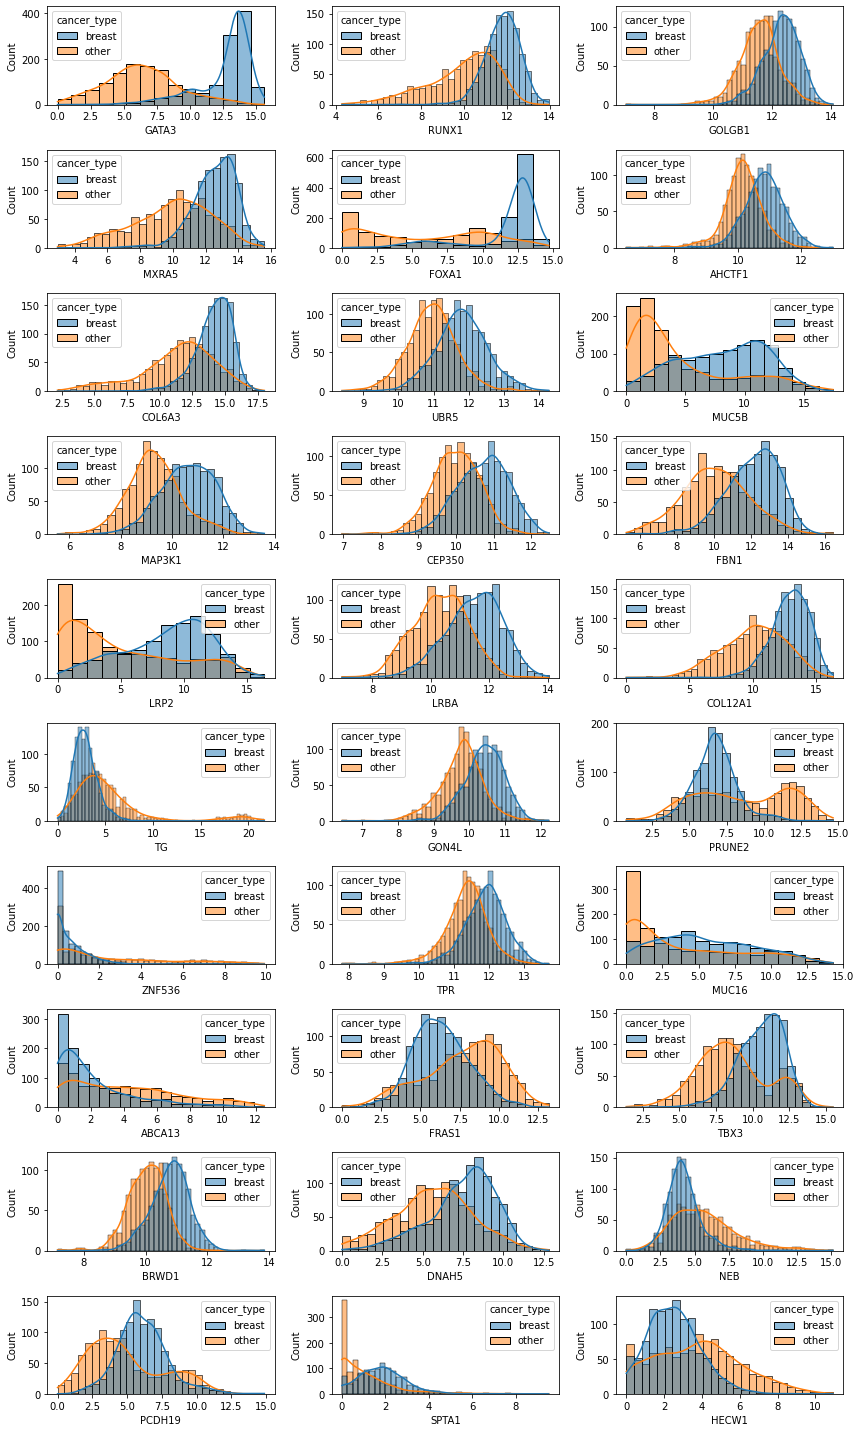

In [ ]:
gene_hist(df_log2, imp_ls2[:30])

# 시도 

df_n : gene_exp_pre.csv

### 이상치 제거 - isolation forest + 모델링

In [ ]:
# df_pre : df_n -> 상위 200개?
df_o = df_pre.copy()
df_o.shape

(2185, 192)

#### 이상치 제거

In [ ]:
df_o

,ABCA12,ABCA13,ABCA8,AFF2,AHCTF1,AHNAK2,AHNAK,AKAP9,AKT1,ANK2,...,VPS13B,VPS13C,VPS13D,VWF,XIRP2,ZAN,ZDBF2,ZFHX4,ZNF536,cancer_type
TCGA-3C-AAAU-01A-11R-A41B-07,321.2220,0.0000,58.5920,7.2378,1749.830,412.9010,58622.30,3243.580,4534.33,51.0095,...,1693.650,3044.030,3426.60,1817.390,0.3447,14.1310,24.1261,143.0330,1.0340,breast
TCGA-3C-AALI-01A-11R-A41B-07,678.6300,1.6313,20.1196,13.0506,1159.330,287.1130,24338.80,4446.980,8177.27,109.2990,...,980.968,2831.970,1570.42,4076.670,0.0000,0.0000,32.0827,125.0680,0.5438,breast
TCGA-3C-AALJ-01A-31R-A41B-07,0.0000,0.9066,52.5839,6.3463,1467.820,330.9160,18409.80,1101.540,6412.51,166.8180,...,1186.760,718.042,1054.40,3398.010,0.0000,0.0000,116.0470,268.3590,0.0000,breast
TCGA-3C-AALK-01A-11R-A41B-07,1430.7000,2.4824,213.4880,33.9264,1288.370,852.2960,27008.30,2193.210,6203.56,211.4190,...,874.224,1230.450,1403.81,3466.690,0.4137,0.8275,95.9868,455.1100,1.6549,breast
TCGA-4H-AAAK-01A-12R-A41B-07,10.2128,0.4255,65.5319,18.7234,1126.380,1209.3600,48499.60,1777.450,4170.64,262.9790,...,1339.570,1265.530,1770.21,2432.340,0.0000,1.7021,106.8080,543.4040,1.7021,breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A4-A5DU-01A-11R-A28H-07,11.4320,361.0110,359.8080,188.3270,643.803,2315.2800,19812.90,1663.660,2965.70,173.8870,...,387.485,1018.050,1027.68,377.256,0.0000,0.0000,279.7830,2.4067,0.0000,other
TCGA-C5-A7CG-01A-11R-A32P-07,284.2990,196.9920,10.6383,19.0756,1243.210,482.7590,10141.20,1480.560,2813.65,429.5670,...,1086.570,1384.450,1982.39,1648.570,0.0000,0.0000,191.8560,287.9680,0.0000,other
TCGA-12-0619-01A-01R-1849-01,71.5914,47.4236,1000.4600,4.1040,1543.090,444.5960,6946.19,913.817,6404.92,2991.3400,...,666.667,814.409,1813.95,6770.630,1.8240,0.0000,229.3660,569.0830,71.1354,other
TCGA-CJ-4907-01A-01R-1426-07,137.5520,10.0495,194.0800,126.5600,1042.320,1413.8300,52797.00,1602.890,3115.02,2154.6700,...,922.038,1886.470,1698.67,60728.600,0.0000,1.5702,374.0280,56.8423,1.2562,other


In [ ]:
df_b = df_o[df_o['cancer_type'] == 'breast']
df_ot = df_o[df_o['cancer_type'] == 'other']

In [ ]:
df_b = df_b.iloc[:, :-1]
df_ot = df_ot.iloc[:, :-1]

In [ ]:
df_b = df_b.T
df_ot = df_ot.T

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 50, max_samples = 50, contamination = float(0.02),
                      max_features = 1.0, bootstrap = False, n_jobs = -1, random_state = None, verbose = 0)

fit = clf.fit(df_b)
pred = clf.predict(df_b)
df_b['anomaly'] = pred
outliers_b = df_b.loc[df_b['anomaly'] == -1]
outlier_index_b = outliers_b.index.tolist()

print(df_b['anomaly'].value_counts())

 1    187
-1      4
Name: anomaly, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 50, max_samples = 50, contamination = float(0.02),
                      max_features = 1.0, bootstrap = False, n_jobs = -1, random_state = None, verbose = 0)

fit = clf.fit(df_ot)
pred = clf.predict(df_ot)
df_ot['anomaly'] = pred
outliers_ot = df_ot.loc[df_ot['anomaly'] == -1]
outlier_index_ot = outliers_ot.index.tolist()

print(df_ot['anomaly'].value_counts())

 1    187
-1      4
Name: anomaly, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
outlier_index_b

['AHNAK', 'COL6A3', 'FLNA', 'MYH9']

In [ ]:
outlier_index_ot

['AHNAK', 'COL6A3', 'FLNA', 'MYH9']

* outlier 범위가 같다

In [ ]:
df_drop_outlier = df_o.drop(columns = outlier_index_b, axis = 1)
df_drop_outlier.shape

(2185, 188)

#### 이상치 제거 모델링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_drop_outlier.iloc[:, :-1]
y = df_drop_outlier.iloc[:, -1]

le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
print(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, random_state = 2, test_size = 0.2, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 2, test_size = 0.2, shuffle = True)

X_train.shape

['breast' 'other']


(1398, 187)

In [ ]:
shape = X_train.shape[1]
shape

187

In [ ]:
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

model,hist = DNN(train, test, val, shape, 50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 54)                10152     
                                                                 
 dense_6 (Dense)             (None, 96)                5280      
                                                                 
 dense_7 (Dense)             (None, 128)               12416     
                                                                 
 dense_8 (Dense)             (None, 54)                6966      
                                                                 
 dense_9 (Dense)             (None, 2)                 110       
                                                                 
Total params: 34,924
Trainable params: 34,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================] 

In [ ]:
# 예측 결과 비교
results = model.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test[i]:
        pass
    else:
        print(pred, ':', y_test[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step
Non-match
pred : orig
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
======== 18 ========
14/14 [==============================] - 0s 2ms/step - loss: 23.3816 - accuracy: 0.9588


[23.38161849975586, 0.9588100910186768]

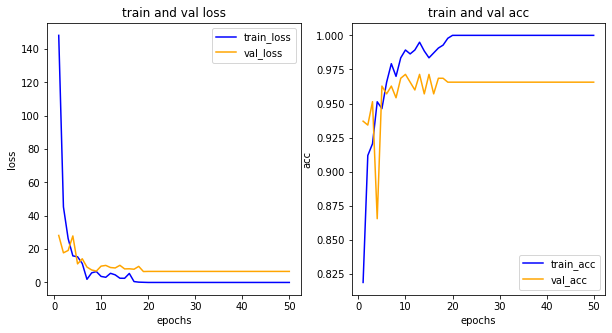

In [ ]:
model_plot(hist)

최적 하이퍼 파라미터:  {'max_depth': 5, 'n_estimators': 30}
최고 예측 정확도: 0.9614
예측 정확도: 0.9748


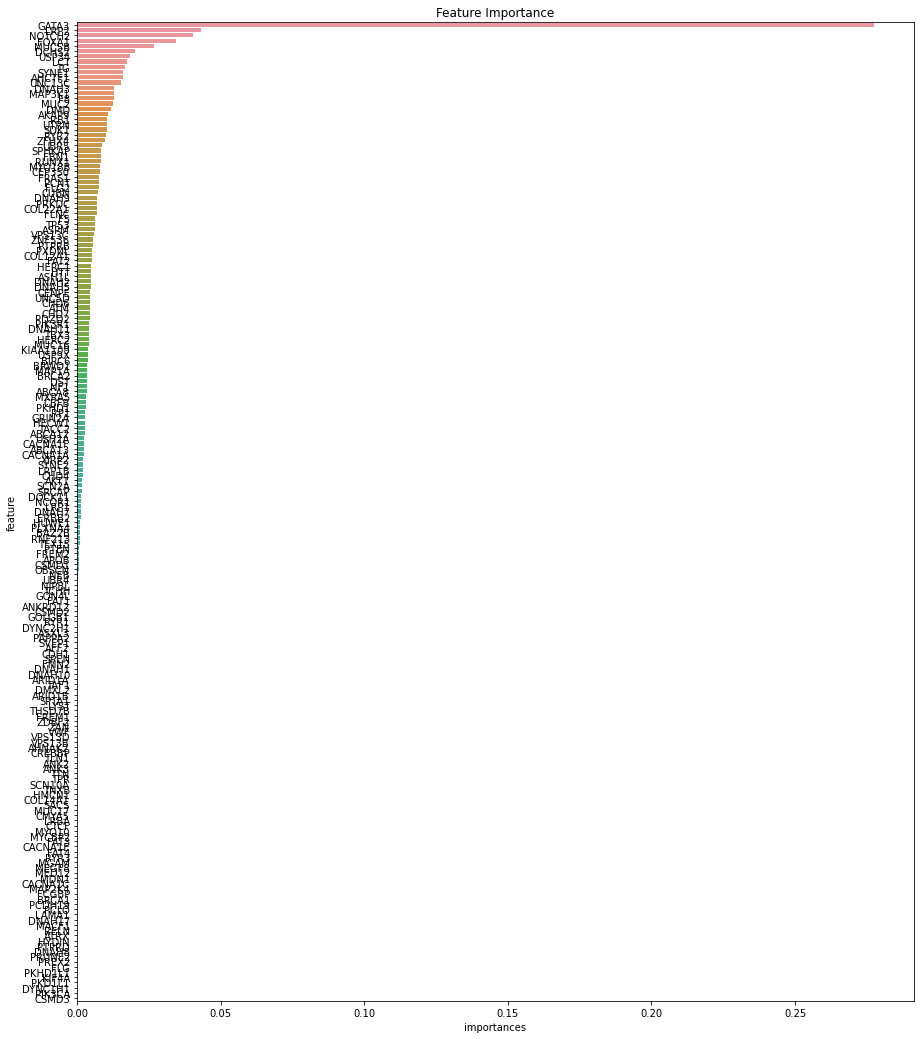

In [ ]:
importances = XGB(train, test, val, 30, 5)

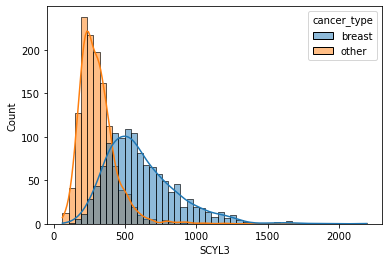

In [ ]:
sns.histplot(data = df_n, x = 'SCYL3', hue = 'cancer_type', kde = True)

In [ ]:
len(df_n.columns)

625

### frequently mutated 200 select 데이터 모델링

In [ ]:
df_n2 = pd.read_csv('/content/drive/MyDrive/KDT_final/data/extract/gene_exp_pre2.csv')
df_n2.head(1)

,AHCTF1,ARID1A,ARID1B,ASH1L,ATM,ATRX,BAZ2B,BIRC6,BRCA1,CBFB,...,PTEN,RB1,RUNX1,SPEN,TAF1,TPR,UBR4,USP34,USP9X,cancer_type
0,1749.83,5379.78,968.491,2815.52,875.433,3326.3,884.998,2214.09,831.317,1342.45,...,1724.33,496.309,7727.25,3909.47,2520.83,2286.97,5421.48,2662.83,8135.33,breast


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X2 = df_n2.iloc[:, :-1]
y2 = df_n2.iloc[:, -1]

le = LabelEncoder()
le.fit(y2)
y_enc2 = le.transform(y2)
print(le.classes_)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y_enc2, random_state = 2, test_size = 0.2, shuffle = True)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, random_state = 2, test_size = 0.2, shuffle = True)

X_train2.shape

['breast' 'other']


(1611, 30)

In [ ]:
shape2 = X_train2.shape[1]
shape2

30

In [ ]:
train2 = (X_train2, y_train2)
test2 = (X_test2, y_test2)
val2 = (X_val2, y_val2)

model2,hist2 = DNN(train2, test2, val2, shape2, 50)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 54)                1674      
                                                                 
 dense_31 (Dense)            (None, 96)                5280      
                                                                 
 dense_32 (Dense)            (None, 128)               12416     
                                                                 
 dense_33 (Dense)            (None, 54)                6966      
                                                                 
 dense_34 (Dense)            (None, 2)                 110       
                                                                 
Total params: 26,446
Trainable params: 26,446
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
51/51 [==============================] 

In [ ]:
# 예측 결과 비교
results2 = model2.predict(X_test2)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test2)):
    pred = np.argmax(results2[i])
    if pred == y_test2[i]:
        pass
    else:
        print(pred, ':', y_test2[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model2.evaluate(X_test2, y_test2)

16/16 [==============================] - 0s 2ms/step
Non-match
pred : orig
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
======== 49 ========
16/16 [==============================] - 0s 2ms/step - loss: 1.4863 - accuracy: 0.9028


[1.486297369003296, 0.9027777910232544]

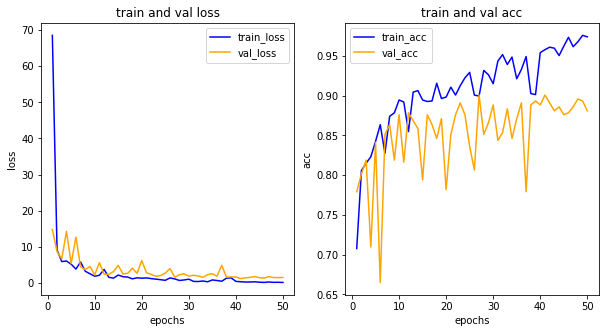

In [ ]:
model_plot(hist2)

### PCA

In [ ]:
# pca input data - data : X / target : X columns

from sklearn.decomposition import PCA

def pca(data, cols, n_component):
    import random
    random.seed(128)
    
    pca = PCA(n_components = n_component)

    pca_check = pca.fit(data)
    pca_array = pca_check.fit_transform(data)

    comp_ls = []
    idx_ls = []
    for i in range(n_component):
        idx = np.argmax(pca_check.components_[i])
        idx_ls.append(idx) # component로 선택된 feature의 인덱스
        c = cols[idx] 
        comp_ls.append(c) # component로 선택된 feature의 name
        imp = pca_check.components_[i][idx]
        print('{0} : {1}'.format(c, imp))
    pca_df = pd.DataFrame(pca_array, columns = comp_ls)

    return pca, pca_df

#### df_n PCA 2

In [ ]:
df_pca = df_n.copy()
df_pca.shape

(2518, 625)

In [ ]:
data = df_pca.iloc[:, 1:624]
target = df_pca.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
target_enc = le.transform(target)
print(le.classes_)

cols = data.columns.tolist()

pca_df = pca(data, cols, 2)

['breast' 'other']
EEF1A1 : 0.9613607287125892
ACTG1 : 0.9539906792251925


In [ ]:
pca_df

,EEF1A1,ACTG1
0,-60193.428599,-6285.860944
1,-49056.187423,31143.575894
2,-22018.676546,34127.331018
3,40416.504045,94942.979007
4,4575.007402,2244.974510
...,...,...
2513,64436.474633,-33781.533634
2514,-5076.929689,18502.358947
2515,23313.380045,-12532.462301
2516,-17556.242385,50688.022168


In [ ]:
pca_df_plot = pca_df.copy()
pca_df_plot['cancer_type'] = df_pca['cancer_type']
pca_df_plot

,EEF1A1,ACTG1,cancer_type
0,-60193.428599,-6285.860944,breast
1,-49056.187423,31143.575894,breast
2,-22018.676546,34127.331018,breast
3,40416.504045,94942.979007,breast
4,4575.007402,2244.974510,breast
...,...,...,...
2513,64436.474633,-33781.533634,other
2514,-5076.929689,18502.358947,other
2515,23313.380045,-12532.462301,other
2516,-17556.242385,50688.022168,other


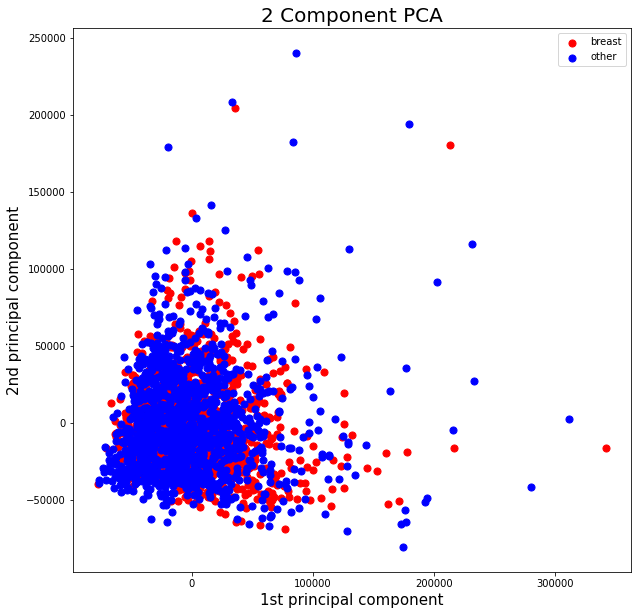

In [ ]:
# PCA 2차원 그래프 그리기
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('1st principal component', fontsize = 15)
ax.set_ylabel('2nd principal component', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['breast','other']
colors = ['r','b']
col_ls = pca_df_plot.columns.tolist()
for target, color in zip(targets, colors):
  indicesToKeep = pca_df_plot['cancer_type'] == target
  ax.scatter(pca_df_plot.loc[indicesToKeep, col_ls[0]], pca_df_plot.loc[indicesToKeep, col_ls[1]], c = color, s = 50)
  ax.legend(targets)
  ax.grid()

In [ ]:
pca_df['cancer_type'] = target_enc

In [ ]:
pca_df.shape

(2518, 3)

In [ ]:
pca_df.head(1)

,EEF1A1,ACTG1,cancer_type
0,-60193.428599,-6285.860944,0


In [ ]:
from sklearn.model_selection import train_test_split

X = pca_df.iloc[:, :-1]
y = pca_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2, test_size = 0.2, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 2, test_size = 0.2, shuffle = True)

X_train.shape

(1611, 2)

In [ ]:
shape = X_train.shape[1]
shape

2

In [ ]:
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

model,hist = DNN(train, test, val, shape, 50)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 54)                162       
                                                                 
 dense_36 (Dense)            (None, 96)                5280      
                                                                 
 dense_37 (Dense)            (None, 128)               12416     
                                                                 
 dense_38 (Dense)            (None, 54)                6966      
                                                                 
 dense_39 (Dense)            (None, 2)                 110       
                                                                 
Total params: 24,934
Trainable params: 24,934
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
51/51 [==============================] 

In [ ]:
results = model.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test.iloc[i]:
        pass
    else:
        print(pred, ':', y_test.iloc[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Non-match
pred : orig
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1

[1.6477704048156738, 0.5317460298538208]

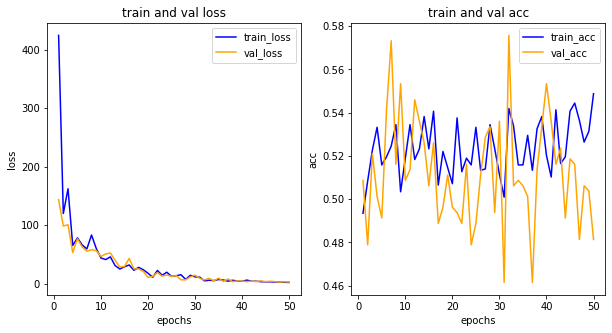

In [ ]:
model_plot(hist)

#### PCA 30

In [ ]:
data = df_pca.iloc[:, 1:624]
target = df_pca.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
target_enc = le.transform(target)
print(le.classes_)

cols = data.columns.tolist()

pca_df_30 = pca(data, cols, 30)

['breast' 'other']
EEF1A1 : 0.9613607287125889
ACTG1 : 0.9539906792251928
UBC : 0.767704140898477
HSPA8 : 0.6065736131798437
HSPA8 : 0.5257894702818546
MSN : 0.6073442315207621
CDH1 : 0.5934585379307421
DDR1 : 0.3426730910459273
HDLBP : 0.5789791681718247
DDR1 : 0.4931000600527329
DDR1 : 0.4089725123601179
CDH1 : 0.23071560686893944
NACA : 0.6232780173076524
RHOA : 0.38735620541839866
ZFP36L1 : 0.4119511660284047
HNRNPA2B1 : 0.3821699451346105
RHOA : 0.4036371468279779
TXNDC5 : 0.542876664388819
PLXNB2 : 0.33872210647478335
CTNNA1 : 0.3056659550304297
HDLBP : 0.24015228990072773
RHOA : 0.3057959284386764
PRPF8 : 0.3042822594505977
SCARB2 : 0.38158302988905
IQGAP1 : 0.36060689019406766
CTNNA1 : 0.32473398096375417
ITGAV : 0.3217800151704662
IQGAP1 : 0.36897201680998853
LAMP2 : 0.38886185914585697
IQGAP1 : 0.43756798491911


In [ ]:
pca_df_30.columns.value_counts()

IQGAP1       3
DDR1         3
RHOA         3
HSPA8        2
CDH1         2
HDLBP        2
CTNNA1       2
EEF1A1       1
PLXNB2       1
ITGAV        1
SCARB2       1
PRPF8        1
ZFP36L1      1
TXNDC5       1
HNRNPA2B1    1
ACTG1        1
NACA         1
MSN          1
UBC          1
LAMP2        1
dtype: int64

In [ ]:
pca_ls = pca_df_30.columns.unique().tolist()
pca_s = pca_df_30.columns.value_counts() > 1
pca_drop_ls = [x for x in pca_ls if pca_s[x] == True]
pca_drop_ls

['HSPA8', 'CDH1', 'DDR1', 'HDLBP', 'RHOA', 'CTNNA1', 'IQGAP1']

In [ ]:
pca_30_col_ls = pca_df_30.columns.tolist()

pca_drop_idx = []
for i in range(len(pca_30_col_ls)):
    if pca_30_col_ls[i] in pca_drop_ls:
        print(i, end = ' ')
        pca_drop_idx.append(i)

3 4 6 7 8 9 10 11 13 16 19 20 21 24 25 27 29 

In [ ]:
pca_df_30.iloc[:, pca_drop_idx].describe()

,HSPA8,HSPA8,CDH1,DDR1,HDLBP,DDR1,DDR1,CDH1,RHOA,RHOA,CTNNA1,HDLBP,RHOA,IQGAP1,CTNNA1,IQGAP1,IQGAP1
count,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2518.000000
mean,1.294531e-12,1.849330e-13,-5.547990e-13,6.010322e-13,1.202064e-12,-1.849330e-13,-8.321985e-13,-1.386997e-13,9.246650e-13,-9.246650e-13,-5.663573e-13,3.236327e-13,8.726526e-13,2.889578e-15,-4.681116e-13,1.386997e-13,0.000000
std,1.200912e+04,9.612584e+03,7.453862e+03,7.024021e+03,6.451225e+03,5.616339e+03,4.920203e+03,4.799612e+03,4.067427e+03,3.486001e+03,2.957007e+03,2.798465e+03,2.645586e+03,2.435640e+03,2.371209e+03,2.240199e+03,2152.739648
min,-4.025799e+04,-3.140974e+04,-2.631833e+04,-2.717724e+04,-2.482181e+04,-2.692498e+04,-1.746979e+04,-1.998002e+04,-1.488841e+04,-1.171796e+04,-1.040172e+04,-1.077305e+04,-9.817853e+03,-1.011375e+04,-1.080685e+04,-1.122642e+04,-9243.170435
25%,-8.210697e+03,-6.592752e+03,-4.943269e+03,-4.201727e+03,-4.307116e+03,-3.611256e+03,-3.270829e+03,-3.261787e+03,-2.734779e+03,-2.223155e+03,-1.931143e+03,-1.772684e+03,-1.702203e+03,-1.521383e+03,-1.418507e+03,-1.289871e+03,-1279.888622
50%,-6.241450e+02,-5.066262e+02,-5.417310e+02,-1.124273e+02,-6.933419e+01,-2.785487e+02,-1.979673e+02,-6.996641e+01,1.238968e+01,-9.223408e+00,-8.670683e+01,-1.017131e+02,-1.457532e+02,-7.357895e+01,9.056523e+01,2.337261e+01,-6.777276
75%,6.928504e+03,6.003617e+03,4.960789e+03,3.558001e+03,4.231464e+03,3.363845e+03,2.978984e+03,3.177256e+03,2.739437e+03,2.231004e+03,1.921512e+03,1.660864e+03,1.572642e+03,1.483681e+03,1.480675e+03,1.351513e+03,1327.188284
max,5.157489e+04,4.668806e+04,3.444352e+04,2.765731e+04,3.287116e+04,3.537796e+04,2.258555e+04,2.614367e+04,1.840859e+04,1.471608e+04,1.237652e+04,1.176383e+04,1.300082e+04,1.119258e+04,1.125984e+04,1.145785e+04,11139.924269


In [ ]:
pca_df_drop = pca_df_30.drop(pca_df_30.columns[[4,10,11,16,20,21,25,26,27,29]], axis = 1)
pca_df_drop.shape

(2518, 12)

In [ ]:
pca_df_drop

,EEF1A1,ACTG1,UBC,MSN,NACA,ZFP36L1,HNRNPA2B1,TXNDC5,PLXNB2,PRPF8,SCARB2,LAMP2
0,-60193.428599,-6285.860944,-10919.374236,-6235.489506,-4797.648862,-937.247735,-14.784440,-963.848759,1932.927040,161.822263,-286.475142,3966.649604
1,-49056.187423,31143.575894,16144.490528,-13018.300287,-8158.137130,5639.197593,3718.516340,1918.975366,-579.725038,-1407.257769,-1579.990791,-357.516430
2,-22018.676546,34127.331018,22141.264342,-11026.113057,-6472.270487,2369.193871,-710.125524,-168.584163,2163.807673,-1224.986759,-1720.539001,2137.903945
3,40416.504045,94942.979007,4781.373630,-4574.506771,160.450006,4492.486297,4744.533851,2298.857401,355.796225,-1348.736560,825.814022,810.809514
4,4575.007402,2244.974510,-2351.533350,-1296.747731,-346.086121,979.412111,244.649866,-1242.220167,-771.081930,-649.264062,128.745566,955.089212
...,...,...,...,...,...,...,...,...,...,...,...,...
2513,64436.474633,-33781.533634,20764.203556,-9098.482793,-6429.656227,-888.044591,2846.682858,2738.682848,-8288.559037,1203.049617,-592.764108,3879.027633
2514,-5076.929689,18502.358947,24042.052108,-1720.351134,2338.362732,-1370.233177,-4521.121892,-1888.270885,1224.377254,-420.181250,3575.648406,2897.916842
2515,23313.380045,-12532.462301,-2730.361521,-12630.549223,-2211.638802,4739.398916,6396.839481,-3451.782172,508.913952,-160.588818,-681.765468,-563.278043
2516,-17556.242385,50688.022168,-14041.284690,-4696.213042,-3079.076195,488.409653,1026.197790,-1108.873317,-5006.662678,-2703.996009,-1536.522168,-1972.460125


In [ ]:
pca_df_drop['cancer_type'] = target_enc
pca_df_drop.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(2518, 13)

In [ ]:
from sklearn.model_selection import train_test_split

X = pca_df_drop.iloc[:, :-1]
y = pca_df_drop.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2, test_size = 0.2, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 2, test_size = 0.2, shuffle = True)

X_train.shape

(1611, 12)

In [ ]:
shape = X_train.shape[1]
shape

12

In [ ]:
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

model,hist = DNN(train, test, val, shape, 50)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 54)                702       
                                                                 
 dense_56 (Dense)            (None, 96)                5280      
                                                                 
 dense_57 (Dense)            (None, 128)               12416     
                                                                 
 dense_58 (Dense)            (None, 54)                6966      
                                                                 
 dense_59 (Dense)            (None, 2)                 110       
                                                                 
Total params: 25,474
Trainable params: 25,474
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
51/51 [==============================]

In [ ]:
results = model.predict(X_test)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results[i])
    if pred == y_test.iloc[i]:
        pass
    else:
        print(pred, ':', y_test.iloc[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Non-match
pred : orig
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
======== 151 ======

[32.02954864501953, 0.7003968358039856]

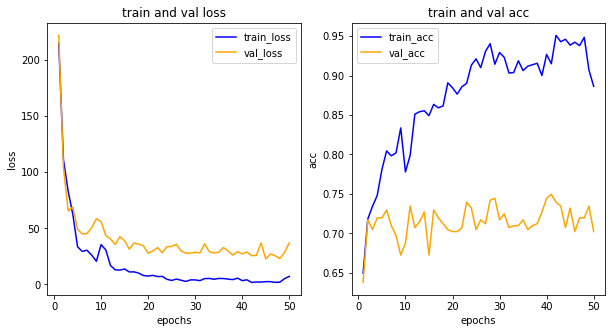

In [ ]:
model_plot(hist)

* 과적합

#### frequently mutated 적용 데이터 PCA 20

In [ ]:
df_pca = df_n2.copy()
df_pca.shape

(2518, 31)

In [ ]:
data = df_pca.iloc[:, 1:30]
target = df_pca.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
target_enc = le.transform(target)
print(le.classes_)

cols = data.columns.tolist()

pca_df_20 = pca(data, cols, 20)

['breast' 'other']
CDH1 : 0.9849268295194264
GOLGB1 : 0.42886924249367975
CHD4 : 0.8246284489915575
RUNX1 : 0.8043568419059349
GOLGB1 : 0.7136745837507441
USP9X : 0.5539798162265418
USP9X : 0.547440845359132
UBR4 : 0.5539820567208151
CREBBP : 0.39426501524471635
NCOR1 : 0.5830925123492963
NCOR1 : 0.39290573788301236
ASH1L : 0.5320372233980669
CREBBP : 0.6219997727520837
ASH1L : 0.3981621896893559
RB1 : 0.6326885475656252
CHD6 : 0.41724079720403967
SPEN : 0.4727394097507126
KIAA1109 : 0.35298255523529776
ARID1B : 0.4916473637783827
ATM : 0.6107329918952775


* CDH1 : 4
* GOLGB1 : 165
* CHD4 : 69
* RUNX1 : 37
* USP9X : 103
* UBR4 : 92
* CREBBP : 197
* NCOR1 : 22
* ASH1L : 116
* RB1 : 127
* CHD6 : 86
* SPEN : 41
* KIAA1109 : 78
* ARUD1B : 184
* ATM : 119
<br></br>
CDH1 : Mutations in this gene are correlated with gastric, breast, colorectal, thyroid and ovarian cancer. <br></br>
ATM : it functions as a regulator of a wide variety of downstream proteins, including tumor suppressor proteins p53 and BRCA1

In [ ]:
pca_df_20.columns.value_counts()

GOLGB1      2
USP9X       2
CREBBP      2
NCOR1       2
ASH1L       2
CDH1        1
CHD4        1
RUNX1       1
UBR4        1
RB1         1
CHD6        1
SPEN        1
KIAA1109    1
ARID1B      1
ATM         1
dtype: int64

In [ ]:
pca_ls = pca_df_20.columns.unique().tolist()
pca_s = pca_df_20.columns.value_counts() > 1
pca_drop_ls = [x for x in pca_ls if pca_s[x] == True]
pca_drop_ls

['GOLGB1', 'USP9X', 'CREBBP', 'NCOR1', 'ASH1L']

In [ ]:
pca_20_col_ls = pca_df_20.columns.tolist()

pca_drop_idx2 = []
for i in range(len(pca_20_col_ls)):
    if pca_20_col_ls[i] in pca_drop_ls:
        print(i, end = ' ')
        pca_drop_idx2.append(i)

1 4 5 6 8 9 10 11 12 13 

In [ ]:
pca_df_20.iloc[:, pca_drop_idx2].describe()

,GOLGB1,GOLGB1,USP9X,USP9X,CREBBP,NCOR1,NCOR1,ASH1L,CREBBP,ASH1L
count,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03,2.518000e+03
mean,1.849330e-13,2.542829e-13,-7.397320e-13,-3.272447e-13,-2.210527e-13,-2.181631e-13,2.210527e-13,3.900930e-14,-8.668734e-15,1.502581e-13
std,3.695937e+03,1.385667e+03,1.300682e+03,1.218698e+03,8.507281e+02,7.803836e+02,7.262550e+02,7.174631e+02,6.668048e+02,6.174580e+02
min,-8.986426e+03,-5.817341e+03,-8.475974e+03,-6.948346e+03,-4.841694e+03,-4.203513e+03,-4.339266e+03,-3.995774e+03,-2.552787e+03,-3.366344e+03
25%,-2.708797e+03,-8.689418e+02,-8.251486e+02,-6.200408e+02,-5.108238e+02,-4.356560e+02,-3.844867e+02,-4.139374e+02,-3.546704e+02,-3.554322e+02
50%,-5.183636e+02,-7.928578e+01,-5.569304e+01,1.639562e+01,-3.634093e+01,-4.881366e+00,2.576303e+01,5.629939e+00,-1.989254e+01,-1.431759e+01
75%,2.420913e+03,8.658285e+02,7.442218e+02,6.869811e+02,5.001159e+02,4.166740e+02,4.115872e+02,4.300160e+02,3.033445e+02,3.309406e+02
max,1.461770e+04,8.430294e+03,8.787438e+03,8.317339e+03,6.169403e+03,5.172682e+03,5.011641e+03,8.581944e+03,4.359689e+03,5.575177e+03


In [ ]:
pca_df_drop2 = pca_df_20.drop(pca_df_20.columns[[4,6,10,12,13]], axis = 1)
pca_df_drop2.shape

(2518, 10)

In [ ]:
pca_df_drop2['cancer_type'] = target_enc
pca_df_drop2.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(2518, 11)

In [ ]:
from sklearn.model_selection import train_test_split

X2 = pca_df_drop2.iloc[:, :-1]
y2 = pca_df_drop2.iloc[:, -1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 2, test_size = 0.2, shuffle = True)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, random_state = 2, test_size = 0.2, shuffle = True)

X_train2.shape

(1611, 10)

In [ ]:
shape2 = X_train2.shape[1]
shape2

10

In [ ]:
train2 = (X_train2, y_train2)
test2 = (X_test2, y_test2)
val2 = (X_val2, y_val2)

model2,hist2 = DNN(train2, test2, val2, shape2, 50)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 54)                594       
                                                                 
 dense_51 (Dense)            (None, 96)                5280      
                                                                 
 dense_52 (Dense)            (None, 128)               12416     
                                                                 
 dense_53 (Dense)            (None, 54)                6966      
                                                                 
 dense_54 (Dense)            (None, 2)                 110       
                                                                 
Total params: 25,366
Trainable params: 25,366
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
51/51 [==============================]

In [ ]:
results2 = model2.predict(X_test2)

print('Non-match')
print('pred : orig')
cnt = 0

for i in range(len(y_test)):
    pred = np.argmax(results2[i])
    if pred == y_test2.iloc[i]:
        pass
    else:
        print(pred, ':', y_test2.iloc[i])
        cnt += 1

print('======== {} ========'.format(cnt))

model2.evaluate(X_test2, y_test2)

16/16 [==============================] - 0s 2ms/step
Non-match
pred : orig
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
1 : 0
0 : 1
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
0 : 1
1 : 0
1 : 0
0 : 1
1 : 0
0 : 1
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
1 : 0
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
0 : 1
0 : 1
1 : 0
0 : 1
======== 147 ========
16/16 [==============

[1.941806674003601, 0.7083333134651184]

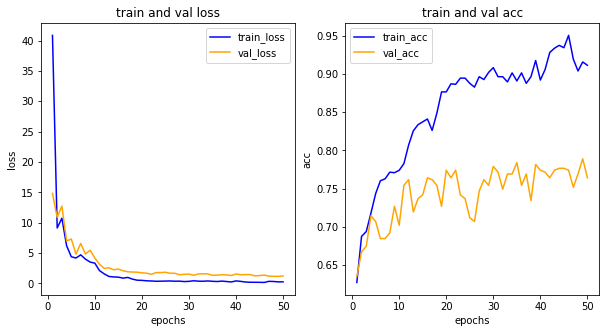

In [ ]:
model_plot(hist2)

#### outlier drop 이후 각각 PCA

In [ ]:
df_brca = df_drop_outlier[df_drop_outlier['cancer_type'] == 'breast']
df_other = df_drop_outlier[df_drop_outlier['cancer_type'] == 'other']

df_brca.shape, df_other.shape

((1218, 612), (1300, 612))

In [ ]:
df_brca.columns.unique()

Index(['ABCB10', 'ABCB7', 'ABCG1', 'ACIN1', 'ACVR2A', 'ADCY7', 'ADD1', 'ADNP2',
       'ADNP', 'ADPRH',
       ...
       'ZNF721', 'ZNF770', 'ZNF786', 'ZNF790', 'ZNF791', 'ZNF800', 'ZNF827',
       'ZNF84', 'ZNF91', 'cancer_type'],
      dtype='object', length=612)

In [ ]:
len(df_brca.columns),len(df_brca.columns.unique()) # 겹치는 컬럼 X

(612, 612)

In [ ]:
# brca PCA
data = df_brca.iloc[:, :-1]
target = df_brca.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
target_enc = le.transform(target)
print(le.classes_)

cols = data.columns.tolist()

pca_brca, brca_comp = pca(data, cols, 50)

['breast']
MAZ : 0.13623851952825267
MSN : 0.5424732636691688
MSN : 0.3174517898158149
WNK1 : 0.09192355730664666
DDR1 : 0.38901209678442306
SCARB2 : 0.2786586645391658
MSN : 0.32725681151623026
DDR1 : 0.65205882610012
CTNNA1 : 0.40255263092147664
IQGAP1 : 0.34894536623004735
IQGAP1 : 0.3964935049125115
PDXDC1 : 0.3632908688988278
PLXNB2 : 0.31332037920513894
KIAA1522 : 0.2826964074297494
CTNNA1 : 0.3807269045878608
SCARB2 : 0.3592671914435072
ENAH : 0.30117146217531443
TTC3 : 0.30550994143558347
CTNNA1 : 0.20824999884629808
WNK1 : 0.2766906075766494
RUNX1 : 0.28358693261190226
KTN1 : 0.31552651521458824
EIF3A : 0.3443764010084932
SNRNP200 : 0.2648156542816578
LAMP2 : 0.4563601953298948
KIAA1522 : 0.24589797520990112
RUNX1 : 0.27101497695197185
SLC39A7 : 0.24050852430350836
FAM120A : 0.19834327423252693
PLXNB2 : 0.275886226057996
EIF3A : 0.23139653950796515
STAT3 : 0.21801219746190204
RUNX1 : 0.3523951920031348
GNAI2 : 0.25453495232545936
JAK1 : 0.27714978354247244
DDX3X : 0.2792160315

In [ ]:
abs(pca_brca.components_)

array([[0.00841308, 0.00577809, 0.00337178, ..., 0.0106983 , 0.00963309,
        0.0218681 ],
       [0.00387999, 0.00159979, 0.04177914, ..., 0.00311182, 0.00845139,
        0.02793938],
       [0.00896838, 0.00155975, 0.01456683, ..., 0.00466355, 0.00697275,
        0.0159061 ],
       ...,
       [0.00609325, 0.00063012, 0.01240149, ..., 0.00319153, 0.01500018,
        0.0271756 ],
       [0.01086849, 0.00455325, 0.07219096, ..., 0.01002221, 0.03551281,
        0.00822494],
       [0.01599766, 0.00247865, 0.00232055, ..., 0.0001014 , 0.01107977,
        0.00855926]])

In [ ]:
abs(pca_brca.components_).shape

(50, 611)

In [ ]:
pca_brca.get_covariance()

array([[167993.01896229,   4933.73094   ,  -2751.61271486, ...,
          6897.96092005,   4914.41636616,  18394.7139982 ],
       [  4933.73094   , 145539.85047194,  -6163.52509608, ...,
          4726.95216131,   5635.65447658,   9074.71152135],
       [ -2751.61271486,  -6163.52509608, 329238.38374797, ...,
         13204.22617712,  19446.24850839,  99745.51341728],
       ...,
       [  6897.96092005,   4726.95216131,  13204.22617712, ...,
        156949.5412246 ,  15009.35407625,  33377.76172227],
       [  4914.41636616,   5635.65447658,  19446.24850839, ...,
         15009.35407625, 192493.35585626,  46636.57442548],
       [ 18394.7139982 ,   9074.71152135,  99745.51341728, ...,
         33377.76172227,  46636.57442548, 274409.81789376]])

In [ ]:
pca_result_brca = pd.DataFrame({'explained_variance' : pca_brca.explained_variance_,
                                'explained_variance_ratio' : pca_brca.explained_variance_ratio_},
                               index = brca_comp.columns)
pca_result_brca['cumulative proportion'] = pca_result_brca['explained_variance_ratio'].cumsum()
pca_result_brca

,explained_variance,explained_variance_ratio,cumulative proportion
MAZ,1.044261e+08,0.202969,0.202969
MSN,4.981888e+07,0.096831,0.299800
MSN,4.306572e+07,0.083705,0.383505
WNK1,2.085832e+07,0.040542,0.424047
DDR1,1.818565e+07,0.035347,0.459393
SCARB2,1.658574e+07,0.032237,0.491630
MSN,1.343622e+07,0.026115,0.517746
DDR1,1.056043e+07,0.020526,0.538272
CTNNA1,9.930244e+06,0.019301,0.557573
IQGAP1,8.785342e+06,0.017076,0.574648


In [ ]:
# other PCA
data = df_other.iloc[:, :-1]
target = df_other.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
target_enc = le.transform(target)
print(le.classes_)

cols = data.columns.tolist()

pca_other, other_comp = pca(data, cols, 50)

['other']
MSN : 0.7077307019364629
DDR1 : 0.5837171603391637
MKI67 : 0.19079409854522092
MSN : 0.35196428701674126
SCARB2 : 0.19905702598185754
PLXNB2 : 0.4190796274455139
DDR1 : 0.41008685703786024
TXNDC5 : 0.3338232032063535
MSN : 0.30993705108053465
LAMP2 : 0.42991038999944436
TXNDC5 : 0.3139215364577998
PLXNB2 : 0.4912630264346755
CTNNA1 : 0.4642733260190935
MAZ : 0.20847242249132394
LAMP2 : 0.3434532304145887
WNK1 : 0.2615278457043355
CTNNA1 : 0.25558872539719135
IGF2R : 0.3471451228990312
PRPF8 : 0.18435310526164536
STAT6 : 0.264527509400481
EIF3A : 0.24920382895958118
KPNB1 : 0.2500116467256003
IQGAP1 : 0.39895750707267114
LAMP2 : 0.3783169326279023
STAT3 : 0.2693691426155714
KTN1 : 0.35870870297079227
UBR4 : 0.20641979394888332
TXNDC5 : 0.21051781973644237
UBR4 : 0.21535947716726214
ITGAV : 0.2891961788790607
STAT6 : 0.25063087017517777
POLR2A : 0.3078496975349771
KIAA1522 : 0.3188550373590519
PRPF8 : 0.20632543269804265
TTC3 : 0.32965733136887604
SNRNP200 : 0.2347207357490324


In [ ]:
pca_result_other = pd.DataFrame({'explained_variance' : pca_brca.explained_variance_,
                                'explained_variance_ratio' : pca_brca.explained_variance_ratio_},
                               index = other_comp.columns)
pca_result_other['cumulative proportion'] = pca_result_other['explained_variance_ratio'].cumsum()
pca_result_other

,explained_variance,explained_variance_ratio,cumulative proportion
MSN,1.044261e+08,0.202969,0.202969
DDR1,4.981888e+07,0.096831,0.299800
MKI67,4.306572e+07,0.083705,0.383505
MSN,2.085832e+07,0.040542,0.424047
SCARB2,1.818565e+07,0.035347,0.459393
PLXNB2,1.658574e+07,0.032237,0.491630
DDR1,1.343622e+07,0.026115,0.517746
TXNDC5,1.056043e+07,0.020526,0.538272
MSN,9.930244e+06,0.019301,0.557573
LAMP2,8.785342e+06,0.017076,0.574648


In [ ]:
len(brca_comp.columns), len(brca_comp.columns.unique())

(50, 31)

In [ ]:
len(other_comp.columns), len(other_comp.columns.unique())

(50, 32)

In [ ]:
g_n = []
other_ls = other_comp.columns.tolist()
brca_ls = brca_comp.columns.tolist()

for n in brca_ls:
    if n in other_ls:
        g_n.append(n)

g_n

['MAZ',
 'MSN',
 'MSN',
 'WNK1',
 'DDR1',
 'SCARB2',
 'MSN',
 'DDR1',
 'CTNNA1',
 'IQGAP1',
 'IQGAP1',
 'PLXNB2',
 'KIAA1522',
 'CTNNA1',
 'SCARB2',
 'ENAH',
 'TTC3',
 'CTNNA1',
 'WNK1',
 'KTN1',
 'EIF3A',
 'SNRNP200',
 'LAMP2',
 'KIAA1522',
 'PLXNB2',
 'EIF3A',
 'STAT3',
 'ITGAV',
 'ITGAV',
 'IGF2R',
 'KPNB1',
 'IGF2R',
 'CHD4',
 'KPNB1']

In [ ]:
len(g_n)

34